## NeurIPS Results Parser

### Imports

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
from env.imports import *

In [83]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn


<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [84]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 4.2%
RAM Usage: 25.4%
Available RAM: 281.2G
Total RAM: 376.8G
52.4G


In [85]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 0


### Parse UKBB final run results

True

In [86]:
# Get all csv files in results folder
results_dir = './notebooks/NeurIPS/results/UKBB_true'
results_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('.csv') and 'results' in file.lower():
            results_files.append(os.path.join(root, file))

# Load each results file into a dataframe
transformer_df = pd.read_csv(os.path.join(results_dir, 'transformer_singlerun_results.csv'))
mlp_pls_df = pd.read_csv(os.path.join(results_dir, 'MLP_PLS_CV_results.csv'))
bilinear_pca_df = pd.read_csv(os.path.join(results_dir, 'bilinear_PCA_CV_results.csv'))
transformer_cls_df = pd.read_csv(os.path.join(results_dir, 'transformer_CLS_4head.csv'))# 'transformer_CLS_singlerun_results.csv'))
mlp_pca_df = pd.read_csv(os.path.join(results_dir, 'MLP_PCA_CV_results.csv'))
bilinear_lowrank_df = pd.read_csv(os.path.join(results_dir, 'bilinear_lowrank_CV_results.csv'))
mlp_df = pd.read_csv(os.path.join(results_dir, 'MLP_CV_results.csv'))
mlp_cls_df = pd.read_csv(os.path.join(results_dir, 'MLP_transcriptome_euclidean_CV_results.csv'))
bilinear_pls_df = pd.read_csv(os.path.join(results_dir, 'bilinear_PLS_CV_results.csv'))

In [87]:
runs = transformer_cls_df['Name'].tolist()

In [88]:
metrics_list = [
    'final_test_metrics.pearson_r',
    'final_test_metrics.r2',
    'final_test_metrics.mse',
    'final_test_metrics.geodesic_distance',
    'final_test_metrics.short_r',
    'final_test_metrics.mid_r',
    'final_test_metrics.long_r',
    'final_train_metrics.pearson_r',
    'final_train_metrics.r2',
    'final_train_metrics.mse',
    'final_train_metrics.geodesic_distance',
    'final_train_metrics.short_r',
    'final_train_metrics.mid_r',
    'final_train_metrics.long_r'
]

# Subset each dataframe to only include the metrics columns
dfs = {
    'transformer_df': transformer_df[metrics_list],
    'mlp_cls_df': mlp_cls_df[metrics_list],
    'mlp_pls_df': mlp_pls_df[metrics_list],
    'bilinear_pca_df': bilinear_pca_df[metrics_list],
    'transformer_cls_df': transformer_cls_df[metrics_list],
    'mlp_pca_df': mlp_pca_df[metrics_list], 
    'bilinear_lowrank_df': bilinear_lowrank_df[metrics_list],
    'mlp_df': mlp_df[metrics_list],
    'bilinear_pls_df': bilinear_pls_df[metrics_list]
}

# Print any missing columns that couldn't be included
for df_name, df in dfs.items():
    missing_cols = [col for col in metrics_list if col not in df.columns]
    if missing_cols:
        print(f"\nMissing columns in {df_name}:")
        for col in missing_cols:
            print(f"  - {col}")


# Print the first few rows of each dataframe and check for NaN values
for df_name, df in dfs.items():
    print(f"\nHead of {df_name}:")
    print(df.head())
    print(f"\nNaN values in {df_name}:")
    print(df.isna().sum())
    print("-" * 80)


# Create a DataFrame to store results
results = pd.DataFrame(index=metrics_list)

# For each model type
for model_name, df in dfs.items():
    # Calculate mean and std for each metric
    mean_col = f"{model_name}_mean"
    std_col = f"{model_name}_std"
    
    # Compute statistics for each metric
    for metric in metrics_list:
        if metric in df.columns:
            mean_val = df[metric].mean()
            std_val = df[metric].std()
            results.loc[metric, mean_col] = mean_val
            results.loc[metric, std_col] = std_val
        else:
            results.loc[metric, mean_col] = np.nan
            results.loc[metric, std_col] = np.nan

# Display results
print("\nMean and standard deviation for each metric across models:")
print(results)





Head of transformer_df:
   final_test_metrics.pearson_r  final_test_metrics.r2  \
0                      0.847029               0.715918   
1                      0.842610               0.705390   
2                      0.831612               0.687694   
3                      0.826214               0.681986   
4                      0.823987               0.674524   

   final_test_metrics.mse  final_test_metrics.geodesic_distance  \
0                0.010897                              9.932060   
1                0.010778                              8.714811   
2                0.012087                              9.922932   
3                0.011846                             10.505120   
4                0.011402                             10.323794   

   final_test_metrics.short_r  final_test_metrics.mid_r  \
0                    0.869464                  0.808334   
1                    0.868142                  0.810349   
2                    0.855749                 

In [89]:
# GLOBAL 

# Define mapping from df names to display names
model_name_mapping = {
    'bilinear_pca_df': 'Bilinear CM (PCA)',
    'bilinear_pls_df': 'Bilinear CM (PLS)', 
    'bilinear_lowrank_df': 'Low-Rank Bilinear',
    'mlp_pca_df': 'MLP (PCA)',
    'mlp_pls_df': 'MLP (PLS)',
    'mlp_df': 'MLP',
    'mlp_cls_df': 'MLP w/ coords',
    'transformer_df': 'SMT',
    'transformer_cls_df': 'SMT w/ CLS'
}


In [90]:
# Combine mean and std dev for test metrics only
formatted_results = pd.DataFrame()
test_metrics = [m for m in metrics_list if m.startswith('final_test_metrics')]

# Define mapping from df names to display names
model_name_mapping = {
    'bilinear_pca_df': 'Bilinear CM (PCA)',
    'bilinear_pls_df': 'Bilinear CM (PLS)', 
    'bilinear_lowrank_df': 'Low-Rank Bilinear',
    'mlp_pca_df': 'MLP (PCA)',
    'mlp_pls_df': 'MLP (PLS)',
    'mlp_df': 'MLP',
    'mlp_cls_df': 'MLP w/ coords',
    'transformer_df': 'SMT',
    'transformer_cls_df': 'SMT w/ CLS'
}

# Define column name mapping
metric_name_mapping = {
    'pearson_r': 'Pearson-r',
    'r2': 'R²',
    'mse': 'MSE',
    'geodesic_distance': 'Geodesic Distance',
    'short_r': 'Short-range r',
    'mid_r': 'Mid-range r', 
    'long_r': 'Long-range r'
}

for metric in test_metrics:
    means = results.loc[metric].filter(like='mean')
    stds = results.loc[metric].filter(like='std')
    
    # Create combined strings of mean ± std
    combined = []
    for m, s in zip(means, stds):
        metric_name = metric.replace('final_test_metrics.', '')
        if metric_name == 'mse':
            mean_val = round(float(m), 3)  # Keep MSE at 3 decimal places
        else:
            mean_val = round(float(m), 2)  # Other metrics at 2 decimal places
        std_val = float(s)
        # Round std to 2 decimal places if possible (if >= 0.01)
        if std_val >= 0.01:
            std_val = round(std_val, 2)
        else:
            std_val = round(std_val, 3)
        combined.append(f"{mean_val} ± {std_val}")
    
    # Create new row with combined values
    model_names = [name.replace('_mean','') for name in means.index]
    # Remove 'final_test_metrics.' prefix and map to formatted name
    metric_name = metric.replace('final_test_metrics.', '')
    metric_name = metric_name_mapping.get(metric_name, metric_name)
    formatted_results[metric_name] = pd.Series(combined, index=model_names)

# Define the desired order of models
model_order = [
    'bilinear_pca_df',
    'bilinear_pls_df',
    'bilinear_lowrank_df',
    'mlp_pca_df', 
    'mlp_pls_df',
    'mlp_df',
    'mlp_cls_df',
    'transformer_df',
    'transformer_cls_df'
]

# Reindex the DataFrame according to the specified order and map index names
formatted_results = formatted_results.reindex(model_order)
formatted_results.index = [model_name_mapping[model] for model in model_order]

# Display the sorted results
formatted_results



,Pearson-r,R²,MSE,Geodesic Distance,Short-range r,Mid-range r,Long-range r
Bilinear CM (PCA),0.5 ± 0.04,0.23 ± 0.04,0.026 ± 0.002,16.08 ± 1.69,0.55 ± 0.05,0.42 ± 0.04,0.33 ± 0.07
Bilinear CM (PLS),0.39 ± 0.09,-1.89 ± 6.23,0.096 ± 0.21,19.2 ± 4.88,0.43 ± 0.1,0.32 ± 0.08,0.27 ± 0.08
Low-Rank Bilinear,0.77 ± 0.04,0.59 ± 0.06,0.014 ± 0.002,11.17 ± 0.68,0.79 ± 0.03,0.74 ± 0.04,0.69 ± 0.07
MLP (PCA),0.75 ± 0.03,0.55 ± 0.06,0.015 ± 0.002,12.51 ± 1.02,0.79 ± 0.03,0.71 ± 0.04,0.61 ± 0.09
MLP (PLS),0.75 ± 0.05,0.56 ± 0.09,0.015 ± 0.003,12.78 ± 0.92,0.78 ± 0.05,0.72 ± 0.06,0.69 ± 0.07
MLP,0.78 ± 0.03,0.59 ± 0.06,0.014 ± 0.002,10.78 ± 1.23,0.81 ± 0.03,0.75 ± 0.04,0.67 ± 0.06
MLP w/ coords,0.81 ± 0.03,0.65 ± 0.05,0.012 ± 0.001,10.62 ± 1.1,0.83 ± 0.03,0.78 ± 0.04,0.73 ± 0.06
SMT,0.79 ± 0.03,0.61 ± 0.05,0.013 ± 0.001,10.87 ± 1.1,0.82 ± 0.03,0.76 ± 0.03,0.68 ± 0.06
SMT w/ CLS,0.82 ± 0.03,0.66 ± 0.05,0.011 ± 0.002,9.88 ± 0.64,0.84 ± 0.03,0.79 ± 0.03,0.76 ± 0.06


In [91]:

# Convert formatted_results to LaTeX table and find best/second best values
latex_table = """\\begin{table}
  \\caption{Performance comparison of different models on gene expression to connectivity prediction}
  \\label{tab:model-comparison}
  \\centering
  \\small
  \\begin{tabular}{lccccccc}
    \\toprule
    Model & Pearson-r & R² & MSE & Geodesic Distance & Short-range r & Mid-range r & Long-range r \\\\
    \\midrule"""

# Helper function to extract numeric value from formatted string
def extract_value(s):
    return float(s.split(' ±')[0])

# Find best and second best values for each column
best_values = {}
second_best_values = {}
for col in formatted_results.columns:
    values = [extract_value(v) for v in formatted_results[col]]
    if col == 'MSE' or col == 'Geodesic Distance':
        # For these metrics, lower is better
        best_values[col] = min(values)
        second_best_values[col] = sorted(values)[1]
    else:
        # For other metrics, higher is better
        best_values[col] = max(values)
        second_best_values[col] = sorted(values, reverse=True)[1]

# Add each row
for model in formatted_results.index:
    row = [model]
    for col in formatted_results.columns:
        value = formatted_results.loc[model, col]
        numeric_val = extract_value(value)
        if numeric_val == best_values[col]:
            value = "\\textbf{" + value + "}"
        elif numeric_val == second_best_values[col]:
            value = "\\textit{" + value + "}"
        row.append(value)
    latex_table += "\n    " + " & ".join(row) + " \\\\"

latex_table += """
    \\bottomrule
  \\end{tabular}
\\end{table}"""

print(latex_table)

\begin{table}
  \caption{Performance comparison of different models on gene expression to connectivity prediction}
  \label{tab:model-comparison}
  \centering
  \small
  \begin{tabular}{lccccccc}
    \toprule
    Model & Pearson-r & R² & MSE & Geodesic Distance & Short-range r & Mid-range r & Long-range r \\
    \midrule
    Bilinear CM (PCA) & 0.5 ± 0.04 & 0.23 ± 0.04 & 0.026 ± 0.002 & 16.08 ± 1.69 & 0.55 ± 0.05 & 0.42 ± 0.04 & 0.33 ± 0.07 \\
    Bilinear CM (PLS) & 0.39 ± 0.09 & -1.89 ± 6.23 & 0.096 ± 0.21 & 19.2 ± 4.88 & 0.43 ± 0.1 & 0.32 ± 0.08 & 0.27 ± 0.08 \\
    Low-Rank Bilinear & 0.77 ± 0.04 & 0.59 ± 0.06 & 0.014 ± 0.002 & 11.17 ± 0.68 & 0.79 ± 0.03 & 0.74 ± 0.04 & 0.69 ± 0.07 \\
    MLP (PCA) & 0.75 ± 0.03 & 0.55 ± 0.06 & 0.015 ± 0.002 & 12.51 ± 1.02 & 0.79 ± 0.03 & 0.71 ± 0.04 & 0.61 ± 0.09 \\
    MLP (PLS) & 0.75 ± 0.05 & 0.56 ± 0.09 & 0.015 ± 0.003 & 12.78 ± 0.92 & 0.78 ± 0.05 & 0.72 ± 0.06 & 0.69 ± 0.07 \\
    MLP & 0.78 ± 0.03 & 0.59 ± 0.06 & 0.014 ± 0.002 & 10.78 ± 1.23

T-test between mlp and smt w/ spatial context

In [108]:
# Perform one-tailed t-tests between SMT w/ CLS and MLP w/ coords
from scipy import stats

# Define the two models to compare
model1_df = transformer_cls_df
model2_df = mlp_cls_df
metrics = [
    'final_test_metrics.pearson_r',
    'final_test_metrics.short_r',
    'final_test_metrics.mid_r',
    'final_test_metrics.long_r', 
    'final_test_metrics.r2',
    'final_test_metrics.mse', 
    'final_test_metrics.geodesic_distance'
]

# Perform t-tests and store results
ttest_results = {}
for metric in metrics:
    # One-tailed t-test
    # For MSE and geodesic distance, we want to test if model1 is less than model2
    if metric in ['final_test_metrics.mse', 'final_test_metrics.geodesic_distance']:
        t_stat, p_val = stats.ttest_ind(model1_df[metric], model2_df[metric], alternative='less')
    else:
        t_stat, p_val = stats.ttest_ind(model1_df[metric], model2_df[metric], alternative='greater')
    ttest_results[metric] = {'t_stat': t_stat, 'p_value': p_val}
    
# Print results
for metric in metrics:
    print(f"\n{metric}:")
    print(f"t-statistic: {ttest_results[metric]['t_stat']:.3f}")
    print(f"p-value: {ttest_results[metric]['p_value']:.3f}")


final_test_metrics.pearson_r:
t-statistic: 1.407
p-value: 0.082

final_test_metrics.short_r:
t-statistic: 0.933
p-value: 0.177

final_test_metrics.mid_r:
t-statistic: 0.970
p-value: 0.168

final_test_metrics.long_r:
t-statistic: 2.521
p-value: 0.007

final_test_metrics.r2:
t-statistic: 0.932
p-value: 0.177

final_test_metrics.mse:
t-statistic: -0.879
p-value: 0.191

final_test_metrics.geodesic_distance:
t-statistic: -3.700
p-value: 0.000


In [114]:
# Extract split information from Name column and reorder columns
transformer_cls_df['split'] = transformer_cls_df['Name'].str.extract(r'(random\d+_fold\d+)')
mlp_cls_df['split'] = mlp_cls_df['Name'].str.extract(r'(random\d+_fold\d+)')

# Reorder columns to put split after Name
cols = list(transformer_cls_df.columns)
cols.remove('split')
cols.insert(1, 'split')
transformer_cls_df = transformer_cls_df[cols]
mlp_cls_df = mlp_cls_df[cols]

# Sort both dataframes by split and reset index to ensure proper alignment
transformer_cls_df = transformer_cls_df.sort_values('split').reset_index(drop=True)
mlp_cls_df = mlp_cls_df.sort_values('split').reset_index(drop=True)


In [115]:
# Check if splits match after sorting by resetting indices first
transformer_splits = transformer_cls_df['split'].reset_index(drop=True)
mlp_splits = mlp_cls_df['split'].reset_index(drop=True)

splits_match = (transformer_splits == mlp_splits).all()
print("All splits match after sorting:", splits_match)

if not splits_match:
    # Find mismatched splits
    mismatched = transformer_splits != mlp_splits
    print("\nMismatched splits:")
    print("SMT w/ CLS splits:", transformer_splits[mismatched].tolist())
    print("MLP w/ coords splits:", mlp_splits[mismatched].tolist())

# Move long_r after test metrics pearson r
cols = list(transformer_cls_df.columns)
long_r_idx = cols.index('final_test_metrics.long_r')
pearson_r_idx = cols.index('final_test_metrics.pearson_r')
cols.insert(pearson_r_idx + 1, cols.pop(long_r_idx))

transformer_cls_df = transformer_cls_df[cols]
mlp_cls_df = mlp_cls_df[cols]

All splits match after sorting: True


In [116]:
transformer_cls_df.head(10)

,Name,split,final_test_metrics.pearson_r,final_test_metrics.long_r,Commit,Runtime,GitHub,Group,Notes,Tags,...,final_train_metrics.geodesic_distance,final_train_metrics.long_r,final_train_metrics.mae,final_train_metrics.mid_r,final_train_metrics.mse,final_train_metrics.pearson_r,final_train_metrics.r2,final_train_metrics.short_r,test_mse_loss,train_mse_loss
0,shared_transformer_cls_transcriptome_FC_random...,random1_fold0,0.833102,0.798236,2112fab8d70677f6be1a5544f0c1fa0d36f18197,675,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_vvl6rd9y,-,"binarize_False, cv_type_random, feature_type_t...",...,12.863116,0.987221,0.022185,0.988025,0.000873,0.988937,0.974725,0.988970,0.009240,0.002257
1,shared_transformer_cls_transcriptome_FC_random...,random1_fold1,0.782191,0.717458,2112fab8d70677f6be1a5544f0c1fa0d36f18197,636,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_vvl6rd9y,-,"binarize_False, cv_type_random, feature_type_t...",...,13.286226,0.984219,0.023249,0.985324,0.000982,0.986966,0.971704,0.987982,0.011834,0.002470
2,shared_transformer_cls_transcriptome_FC_random...,random1_fold2,0.812716,0.813028,2112fab8d70677f6be1a5544f0c1fa0d36f18197,637,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_vvl6rd9y,-,"binarize_False, cv_type_random, feature_type_t...",...,13.295895,0.983438,0.025186,0.983637,0.001159,0.984906,0.963874,0.985255,0.013030,0.002742
3,shared_transformer_cls_transcriptome_FC_random...,random1_fold3,0.810706,0.755786,2112fab8d70677f6be1a5544f0c1fa0d36f18197,638,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_vvl6rd9y,-,"binarize_False, cv_type_random, feature_type_t...",...,13.225572,0.984276,0.024304,0.984103,0.001070,0.985428,0.967403,0.985766,0.012866,0.002591
4,shared_transformer_cls_transcriptome_FC_random...,random2_fold0,0.750179,0.518141,2112fab8d70677f6be1a5544f0c1fa0d36f18197,668,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_10swngxg,-,"binarize_False, cv_type_random, feature_type_t...",...,13.586782,0.982566,0.025792,0.983750,0.001207,0.985028,0.964622,0.985359,0.014283,0.002910
5,shared_transformer_cls_transcriptome_FC_random...,random2_fold1,0.837772,0.827279,2112fab8d70677f6be1a5544f0c1fa0d36f18197,629,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_10swngxg,-,"binarize_False, cv_type_random, feature_type_t...",...,13.114073,0.985563,0.022765,0.986505,0.000947,0.987319,0.970583,0.987316,0.011170,0.003247
6,shared_transformer_cls_transcriptome_FC_random...,random2_fold2,0.817833,0.793259,2112fab8d70677f6be1a5544f0c1fa0d36f18197,627,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_10swngxg,-,"binarize_False, cv_type_random, feature_type_t...",...,13.248940,0.984775,0.022466,0.986378,0.000919,0.987381,0.973785,0.988103,0.009862,0.003040
7,shared_transformer_cls_transcriptome_FC_random...,random2_fold3,0.844123,0.760265,2112fab8d70677f6be1a5544f0c1fa0d36f18197,633,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_10swngxg,-,"binarize_False, cv_type_random, feature_type_t...",...,13.182522,0.986764,0.022647,0.986944,0.000911,0.988614,0.972164,0.989535,0.010751,0.002521
8,shared_transformer_cls_transcriptome_FC_random...,random3_fold0,0.818464,0.770441,2112fab8d70677f6be1a5544f0c1fa0d36f18197,672,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_s8vyuvl1,-,"binarize_False, cv_type_random, feature_type_t...",...,13.764979,0.983285,0.022805,0.984249,0.000951,0.986071,0.970122,0.986838,0.012741,0.002069
9,shared_transformer_cls_transcriptome_FC_random...,random3_fold1,0.869224,0.834788,2112fab8d70677f6be1a5544f0c1fa0d36f18197,635,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_s8vyuvl1,-,"binarize_False, cv_type_random, feature_type_t...",...,14.046947,0.987459,0.022413,0.987369,0.000903,0.988391,0.973101,0.988649,0.008416,0.002588


In [117]:
mlp_cls_df.head(10)

,Name,split,final_test_metrics.pearson_r,final_test_metrics.long_r,Commit,Runtime,GitHub,Group,Notes,Tags,...,final_train_metrics.geodesic_distance,final_train_metrics.long_r,final_train_metrics.mae,final_train_metrics.mid_r,final_train_metrics.mse,final_train_metrics.pearson_r,final_train_metrics.r2,final_train_metrics.short_r,test_mse_loss,train_mse_loss
0,dynamic_mlp_transcriptome+euclidean_FC_random1...,random1_fold0,0.828408,0.779780,4a3c7e0682ca5f0ec5d25b3bdef89c7182faa223,4053,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_8r76pmjc,-,"binarize_False, cv_type_random, feature_type_t...",...,13.574141,0.978935,0.028265,0.978119,0.001418,0.980153,0.958965,0.979766,0.009377,0.002428
1,dynamic_mlp_transcriptome+euclidean_FC_random1...,random1_fold1,0.785022,0.709373,08fdb690224e6aaa4eea0f719ef9d1e1e46d47b5,2573,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_8r76pmjc,-,"binarize_False, cv_type_random, feature_type_t...",...,13.748535,0.986848,0.019143,0.989407,0.000660,0.990599,0.980996,0.991432,0.011797,0.002133
2,dynamic_mlp_transcriptome+euclidean_FC_random1...,random1_fold2,0.852371,0.803807,08fdb690224e6aaa4eea0f719ef9d1e1e46d47b5,5366,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_9gvs8vtx,-,"binarize_False, cv_type_random, feature_type_t...",...,15.352675,0.981625,0.024805,0.982634,0.001172,0.982822,0.963479,0.982251,0.010699,0.002778
3,dynamic_mlp_transcriptome+euclidean_FC_random1...,random1_fold3,0.801934,0.687761,08fdb690224e6aaa4eea0f719ef9d1e1e46d47b5,4417,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_wsizkb47,-,"binarize_False, cv_type_random, feature_type_t...",...,13.827845,0.991772,0.015353,0.992975,0.000413,0.993723,0.987425,0.994172,0.013155,0.000795
4,dynamic_mlp_transcriptome+euclidean_FC_random2...,random2_fold0,0.783830,0.611132,4a3c7e0682ca5f0ec5d25b3bdef89c7182faa223,6086,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_6tazkndy,-,"binarize_False, cv_type_random, feature_type_t...",...,13.966968,0.990408,0.017480,0.991342,0.000544,0.992130,0.984066,0.992354,0.012333,0.002306
5,dynamic_mlp_transcriptome+euclidean_FC_random2...,random2_fold1,0.846588,0.850080,08fdb690224e6aaa4eea0f719ef9d1e1e46d47b5,6150,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_6tazkndy,-,"binarize_False, cv_type_random, feature_type_t...",...,13.911392,0.989287,0.018150,0.990558,0.000593,0.991206,0.981587,0.991168,0.010691,0.002334
6,dynamic_mlp_transcriptome+euclidean_FC_random2...,random2_fold2,0.816510,0.782907,08fdb690224e6aaa4eea0f719ef9d1e1e46d47b5,3626,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_6folt4ym,-,"binarize_False, cv_type_random, feature_type_t...",...,13.904438,0.992243,0.015463,0.993443,0.000411,0.994169,0.988286,0.994745,0.009750,0.000687
7,dynamic_mlp_transcriptome+euclidean_FC_random2...,random2_fold3,0.797477,0.705420,08fdb690224e6aaa4eea0f719ef9d1e1e46d47b5,3872,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_tajbpw9o,-,"binarize_False, cv_type_random, feature_type_t...",...,17.886470,0.963490,0.034144,0.963473,0.002441,0.963850,0.925396,0.961744,0.013410,0.005355
8,dynamic_mlp_transcriptome+euclidean_FC_random3...,random3_fold0,0.856759,0.833732,4a3c7e0682ca5f0ec5d25b3bdef89c7182faa223,5458,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_7ne8plsh,-,"binarize_False, cv_type_random, feature_type_t...",...,13.860431,0.985972,0.020692,0.986378,0.000777,0.987860,0.975585,0.988210,0.010239,0.002682
9,dynamic_mlp_transcriptome+euclidean_FC_random3...,random3_fold1,0.828591,0.780419,08fdb690224e6aaa4eea0f719ef9d1e1e46d47b5,5485,https://github.com/neuroinfolab/GeneEx2Conn/tr...,sweep_7ne8plsh,-,"binarize_False, cv_type_random, feature_type_t...",...,13.919226,0.986135,0.021267,0.986690,0.000816,0.987808,0.975687,0.987997,0.010613,0.002856


In [120]:
# Calculate differences between models
long_range_diffs = abs(transformer_cls_df['final_test_metrics.long_r'] - mlp_cls_df['final_test_metrics.long_r'])
geodesic_diffs = abs(mlp_cls_df['final_test_metrics.geodesic_distance'] - transformer_cls_df['final_test_metrics.geodesic_distance'])

print(long_range_diffs)
print(geodesic_diffs)
# Get indices of top 10 largest differences for each metric
largest_long_range_idx = long_range_diffs.nlargest(10).index
largest_geodesic_idx = geodesic_diffs.nlargest(10).index

print("\nTop 10 largest long-range correlation differences:")
for idx in largest_long_range_idx:
    split = transformer_cls_df.loc[idx, 'split']
    smt_val = transformer_cls_df.loc[idx, 'final_test_metrics.long_r']
    mlp_val = mlp_cls_df.loc[idx, 'final_test_metrics.long_r']
    diff = abs(smt_val - mlp_val)
    print(f"Split {split}:")
    print(f"SMT w/ CLS: {smt_val:.3f}")
    print(f"MLP w/ coords: {mlp_val:.3f}") 
    print(f"Absolute difference: {diff:.3f}\n")

print("\nTop 10 largest geodesic distance differences:")
for idx in largest_geodesic_idx:
    split = transformer_cls_df.loc[idx, 'split']
    smt_val = transformer_cls_df.loc[idx, 'final_test_metrics.geodesic_distance']
    mlp_val = mlp_cls_df.loc[idx, 'final_test_metrics.geodesic_distance']
    diff = abs(mlp_val - smt_val)
    print(f"Split {split}:")
    print(f"SMT w/ CLS: {smt_val:.3f}")
    print(f"MLP w/ coords: {mlp_val:.3f}")
    print(f"Absolute difference: {diff:.3f}\n")

# Find indices that appear in both top 10 lists
common_indices = set(largest_long_range_idx).intersection(set(largest_geodesic_idx))

if len(common_indices) > 0:
    print("\nSplits appearing in both top 10 lists:")
    for idx in common_indices:
        split = transformer_cls_df.loc[idx, 'split']
        print(f"\nSplit: {split}")
        print(f"Long-range correlation:")
        print(f"SMT w/ CLS: {transformer_cls_df.loc[idx, 'final_test_metrics.long_r']:.3f}")
        print(f"MLP w/ coords: {mlp_cls_df.loc[idx, 'final_test_metrics.long_r']:.3f}")
        print(f"Geodesic distance:")
        print(f"SMT w/ CLS: {transformer_cls_df.loc[idx, 'final_test_metrics.geodesic_distance']:.3f}")
        print(f"MLP w/ coords: {mlp_cls_df.loc[idx, 'final_test_metrics.geodesic_distance']:.3f}")
else:
    print("\nNo splits appear in both top 10 lists")


0     0.018455
1     0.008085
2     0.009221
3     0.068025
4     0.092991
5     0.022801
6     0.010353
7     0.054845
8     0.063291
9     0.054369
10    0.127439
11    0.065134
12    0.080054
13    0.028180
14    0.136042
15    0.068419
16    0.052431
17    0.054476
18    0.062572
19    0.074347
20    0.001932
21    0.014749
22    0.073669
23    0.039692
24    0.061830
25    0.036424
26    0.118591
27    0.055974
28    0.060589
29    0.024992
30    0.021332
31    0.036728
32    0.030683
33    0.009135
34    0.083254
35    0.037471
36    0.082946
37    0.013240
38    0.097692
39    0.109522
Name: final_test_metrics.long_r, dtype: float64
0     0.431031
1     1.108152
2     0.407817
3     0.875957
4     0.690456
5     0.664101
6     1.568544
7     3.507338
8     0.160737
9     0.058909
10    0.409196
11    1.973726
12    0.646282
13    1.126414
14    0.399331
15    1.268386
16    1.976935
17    0.086431
18    1.697488
19    2.662390
20    0.351060
21    1.102855
22    2.747562
23    0

Null

In [13]:
# Get all csv files in results folder
results_dir = './notebooks/NeurIPS/results/UKBB_null'
results_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('.csv'):
            results_files.append(os.path.join(root, file))

print(results_files)

# Load each results file into a dataframe
transformer_df = pd.read_csv(f'{results_dir}/transformer_null.csv')
mlp_cls_df = pd.read_csv(f'{results_dir}/MLP_cls_null.csv')
mlp_pls_df = pd.read_csv(f'{results_dir}/MLP_PLS_null.csv')
bilinear_pca_df = pd.read_csv(f'{results_dir}/bilinear_PCA_null.csv')
transformer_cls_df = pd.read_csv(f'{results_dir}/transformer_CLS_null_4head.csv')
mlp_pca_df = pd.read_csv(f'{results_dir}/MLP_PCA_null.csv')
bilinear_lowrank_df = pd.read_csv(f'{results_dir}/bilinear_lowrank_null.csv')
mlp_df = pd.read_csv(f'{results_dir}/MLP_null.csv')
bilinear_pls_df = pd.read_csv(f'{results_dir}/bilinear_PLS_null.csv')

['./notebooks/NeurIPS/results/UKBB_null/transformer_CLS_null_4head.csv', './notebooks/NeurIPS/results/UKBB_null/bilinear_PCA_null.csv', './notebooks/NeurIPS/results/UKBB_null/bilinear_PLS_null.csv', './notebooks/NeurIPS/results/UKBB_null/MLP_PLS_null.csv', './notebooks/NeurIPS/results/UKBB_null/MLP_null.csv', './notebooks/NeurIPS/results/UKBB_null/bilinear_lowrank_null.csv', './notebooks/NeurIPS/results/UKBB_null/MLP_cls_null.csv', './notebooks/NeurIPS/results/UKBB_null/transformer_null.csv', './notebooks/NeurIPS/results/UKBB_null/MLP_PCA_null.csv', './notebooks/NeurIPS/results/UKBB_null/transformer_CLS_null.csv']


In [14]:
# Subset each dataframe to only include the metrics columns
dfs = {
    'transformer_df': transformer_df[metrics_list],
    'mlp_pls_df': mlp_pls_df[metrics_list],
    'mlp_cls_df': mlp_cls_df[metrics_list],
    'bilinear_pca_df': bilinear_pca_df[metrics_list],
    'transformer_cls_df': transformer_cls_df[metrics_list],
    'mlp_pca_df': mlp_pca_df[metrics_list], 
    'bilinear_lowrank_df': bilinear_lowrank_df[metrics_list],
    'mlp_df': mlp_df[metrics_list],
    'bilinear_pls_df': bilinear_pls_df[metrics_list]
}

# Print any missing columns that couldn't be included
for df_name, df in dfs.items():
    missing_cols = [col for col in metrics_list if col not in df.columns]
    if missing_cols:
        print(f"\nMissing columns in {df_name}:")
        for col in missing_cols:
            print(f"  - {col}")


# Print the first few rows of each dataframe and check for NaN values
for df_name, df in dfs.items():
    print(f"\nHead of {df_name}:")
    print(df.head())
    print(f"\nNaN values in {df_name}:")
    print(df.isna().sum())
    print("-" * 80)


# Create a DataFrame to store results
results = pd.DataFrame(index=metrics_list)

# For each model type
for model_name, df in dfs.items():
    # Calculate mean and std for each metric
    mean_col = f"{model_name}_mean"
    std_col = f"{model_name}_std"
    
    # Compute statistics for each metric
    for metric in metrics_list:
        if metric in df.columns:
            mean_val = df[metric].mean()
            std_val = df[metric].std()
            results.loc[metric, mean_col] = mean_val
            results.loc[metric, std_col] = std_val
        else:
            results.loc[metric, mean_col] = np.nan
            results.loc[metric, std_col] = np.nan

# Display results
print("\nMean and standard deviation for each metric across models:")
print(results)



Head of transformer_df:
   final_test_metrics.pearson_r  final_test_metrics.r2  \
0                      0.541124               0.211401   
1                      0.463915               0.159516   
2                      0.388625              -0.070739   
3                      0.425932               0.077043   
4                      0.326737              -0.132401   

   final_test_metrics.mse  final_test_metrics.geodesic_distance  \
0                0.028849                             14.199189   
1                0.029335                             15.776731   
2                0.031351                             15.918628   
3                0.031948                             15.342939   
4                0.034943                             17.362362   

   final_test_metrics.short_r  final_test_metrics.mid_r  \
0                    0.533169                  0.472186   
1                    0.450972                  0.419660   
2                    0.374148                 

In [15]:
# Combine mean and std dev for test metrics only
formatted_results = pd.DataFrame()
test_metrics = [m for m in metrics_list if m.startswith('final_test_metrics')]

# Define column name mapping
metric_name_mapping = {
    'pearson_r': 'Pearson-r',
    'r2': 'R²',
    'mse': 'MSE',
    'geodesic_distance': 'Geodesic Distance',
    'short_r': 'Short-range r',
    'mid_r': 'Mid-range r', 
    'long_r': 'Long-range r'
}

for metric in test_metrics:
    means = results.loc[metric].filter(like='mean')
    stds = results.loc[metric].filter(like='std')
    
    # Create combined strings of mean ± std
    combined = []
    for m, s in zip(means, stds):
        metric_name = metric.replace('final_test_metrics.', '')
        if metric_name == 'mse':
            mean_val = round(float(m), 3)  # Keep MSE at 3 decimal places
        else:
            mean_val = round(float(m), 2)  # Other metrics at 2 decimal places
        std_val = float(s)
        # Round std to 2 decimal places if possible (if >= 0.01)
        if std_val >= 0.01:
            std_val = round(std_val, 2)
        else:
            std_val = round(std_val, 3)
        combined.append(f"{mean_val} ± {std_val}")
    
    # Create new row with combined values
    model_names = [name.replace('_mean','') for name in means.index]
    # Remove 'final_test_metrics.' prefix and map to formatted name
    metric_name = metric.replace('final_test_metrics.', '')
    metric_name = metric_name_mapping.get(metric_name, metric_name)
    formatted_results[metric_name] = pd.Series(combined, index=model_names)

# Define the desired order of models
model_order = [
    'bilinear_pca_df',
    'bilinear_pls_df',
    'bilinear_lowrank_df',
    'mlp_pca_df', 
    'mlp_pls_df',
    'mlp_df',
    'mlp_cls_df',
    'transformer_df',
    'transformer_cls_df'
]

# Reindex the DataFrame according to the specified order and map index names
formatted_results = formatted_results.reindex(model_order)
formatted_results.index = [model_name_mapping[model] for model in model_order]

# Display the sorted results
formatted_results

,Pearson-r,R²,MSE,Geodesic Distance,Short-range r,Mid-range r,Long-range r
Bilinear CM (PCA),0.29 ± 0.07,0.07 ± 0.05,0.031 ± 0.003,20.74 ± 3.8,0.31 ± 0.08,0.2 ± 0.07,0.23 ± 0.07
Bilinear CM (PLS),0.27 ± 0.08,-4.87 ± 25.03,0.208 ± 0.92,20.46 ± 4.22,0.28 ± 0.08,0.2 ± 0.07,0.2 ± 0.08
Low-Rank Bilinear,0.42 ± 0.08,0.16 ± 0.08,0.028 ± 0.004,16.84 ± 1.66,0.42 ± 0.08,0.35 ± 0.08,0.34 ± 0.12
MLP (PCA),0.41 ± 0.07,0.13 ± 0.08,0.029 ± 0.004,18.08 ± 1.34,0.41 ± 0.07,0.34 ± 0.07,0.33 ± 0.09
MLP (PLS),0.39 ± 0.07,0.14 ± 0.08,0.029 ± 0.003,19.49 ± 1.5,0.38 ± 0.07,0.33 ± 0.07,0.31 ± 0.1
MLP,0.3 ± 0.08,-0.22 ± 0.15,0.041 ± 0.006,15.23 ± 1.08,0.31 ± 0.08,0.24 ± 0.08,0.23 ± 0.1
MLP w/ coords,0.47 ± 0.08,0.11 ± 0.13,0.03 ± 0.005,14.31 ± 1.2,0.48 ± 0.08,0.39 ± 0.08,0.36 ± 0.11
SMT,0.33 ± 0.09,-0.08 ± 0.12,0.037 ± 0.005,16.45 ± 1.37,0.33 ± 0.09,0.28 ± 0.09,0.27 ± 0.12
SMT w/ CLS,0.71 ± 0.05,0.47 ± 0.09,0.018 ± 0.003,11.52 ± 0.84,0.73 ± 0.05,0.67 ± 0.05,0.65 ± 0.08


In [16]:
# Convert formatted_results to LaTeX table and find best/second best values
latex_table = """\\begin{table}
  \\caption{Performance comparison of different models on gene expression to connectivity prediction}
  \\label{tab:model-comparison}
  \\centering
  \\small
  \\begin{tabular}{lccccccc}
    \\toprule
    Model & Pearson-r & R² & MSE & Geodesic Distance & Short-range r & Mid-range r & Long-range r \\\\
    \\midrule"""

# Helper function to extract numeric value from formatted string
def extract_value(s):
    return float(s.split(' ±')[0])

# Find best and second best values for each column
best_values = {}
second_best_values = {}
for col in formatted_results.columns:
    values = [extract_value(v) for v in formatted_results[col]]
    if col == 'MSE' or col == 'Geodesic Distance':
        # For these metrics, lower is better
        best_values[col] = min(values)
        second_best_values[col] = sorted(values)[1]
    else:
        # For other metrics, higher is better
        best_values[col] = max(values)
        second_best_values[col] = sorted(values, reverse=True)[1]

# Add each row
for model in formatted_results.index:
    row = [model + " \\textit{(null)}"]  # Add (null) in italics after model name
    for col in formatted_results.columns:
        value = formatted_results.loc[model, col]
        numeric_val = extract_value(value)
        if numeric_val == best_values[col]:
            value = "\\textbf{" + value + "}"
        elif numeric_val == second_best_values[col]:
            value = "\\textit{" + value + "}"
        row.append(value)
    latex_table += "\n    " + " & ".join(row) + " \\\\"

latex_table += """
    \\bottomrule
  \\end{tabular}
\\end{table}"""

print(latex_table)

\begin{table}
  \caption{Performance comparison of different models on gene expression to connectivity prediction}
  \label{tab:model-comparison}
  \centering
  \small
  \begin{tabular}{lccccccc}
    \toprule
    Model & Pearson-r & R² & MSE & Geodesic Distance & Short-range r & Mid-range r & Long-range r \\
    \midrule
    Bilinear CM (PCA) \textit{(null)} & 0.29 ± 0.07 & 0.07 ± 0.05 & 0.031 ± 0.003 & 20.74 ± 3.8 & 0.31 ± 0.08 & 0.2 ± 0.07 & 0.23 ± 0.07 \\
    Bilinear CM (PLS) \textit{(null)} & 0.27 ± 0.08 & -4.87 ± 25.03 & 0.208 ± 0.92 & 20.46 ± 4.22 & 0.28 ± 0.08 & 0.2 ± 0.07 & 0.2 ± 0.08 \\
    Low-Rank Bilinear \textit{(null)} & 0.42 ± 0.08 & \textit{0.16 ± 0.08} & \textit{0.028 ± 0.004} & 16.84 ± 1.66 & 0.42 ± 0.08 & 0.35 ± 0.08 & 0.34 ± 0.12 \\
    MLP (PCA) \textit{(null)} & 0.41 ± 0.07 & 0.13 ± 0.08 & 0.029 ± 0.004 & 18.08 ± 1.34 & 0.41 ± 0.07 & 0.34 ± 0.07 & 0.33 ± 0.09 \\
    MLP (PLS) \textit{(null)} & 0.39 ± 0.07 & 0.14 ± 0.08 & 0.029 ± 0.003 & 19.49 ± 1.5 & 0.38 ± 0.07 

### Ablation experiment

In [17]:
# Get all csv files in results folder
results_dir = './notebooks/NeurIPS/results/ablation/'
results_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('.csv'):
            results_files.append(os.path.join(root, file))

print(results_files)

# Create a dictionary to store DataFrames
ablation_dfs = {}

# Load each CSV file and store in dictionary with descriptive name
ablation_dfs['cls_no_slope'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_CLS_no_slope.csv')
ablation_dfs['cls_no_slope_no_aug'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_CLS_no_slope_no_aug.csv')
ablation_dfs['no_slope_no_cls'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_noslope_nocls.csv')
ablation_dfs['no_slope_no_aug_no_cls'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_noslope_noaug_nocls.csv')
ablation_dfs['no_cls'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_noCLS.csv')
ablation_dfs['full_model'] = pd.read_csv('./notebooks/NeurIPS/results/ablation/transformer_CLS_all.csv')

# Print info about each DataFrame
for name, df in ablation_dfs.items():
    print(f"\n{name}:")
    print(df.info())


['./notebooks/NeurIPS/results/ablation/transformer_CLS_no_slope.csv', './notebooks/NeurIPS/results/ablation/transformer_CLS_no_slope_no_aug.csv', './notebooks/NeurIPS/results/ablation/transformer_noslope_nocls.csv', './notebooks/NeurIPS/results/ablation/transformer_noslope_noaug_nocls.csv', './notebooks/NeurIPS/results/ablation/transformer_noCLS.csv', './notebooks/NeurIPS/results/ablation/transformer_CLS_all.csv']

cls_no_slope:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   40 non-null     object 
 1   final_test_metrics.pearson_r           40 non-null     float64
 2   Commit                                 40 non-null     object 
 3   Created                                40 non-null     object 
 4   Runtime                                40 non-null 

In [18]:
ablation_latex_no_std = """\\begin{table}[h]
  \\caption{Ablation Study Results}
  \\label{tab:ablation}
  \\begin{tabular}{lccccccc}
    \\toprule
    Model & Pearson-r & R² & MSE & Geodesic & Short-r & Mid-r & Long-r \\\\
    \\midrule"""

# Define model name mapping
model_name_map = {
    'no_slope_no_aug_no_cls': 'Base SMT',
    'no_slope_no_cls': 'Base SMT + Target Aug',
    'no_cls': 'Base SMT + Target Aug + Slope',
    'cls_no_slope_no_aug': 'SMT w/ CLS',
    'cls_no_slope': 'SMT w/ CLS + Target Aug',
    'full_model': 'SMT w/ CLS + Target Aug + Slope'
}

# Define order of models
model_order = [
    'no_slope_no_aug_no_cls',
    'no_slope_no_cls', 
    'no_cls',
    'cls_no_slope_no_aug',
    'cls_no_slope',
    'full_model'
]

# Add each row without std dev
for model_key in model_order:
    df = ablation_dfs[model_key]
    row = [model_name_map[model_key]]
    
    # Add metrics without std dev
    row.append(str(round(df['final_test_metrics.pearson_r'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.r2'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.mse'].mean(), 3)))
    row.append(str(round(df['final_test_metrics.geodesic_distance'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.short_r'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.mid_r'].mean(), 2)))
    row.append(str(round(df['final_test_metrics.long_r'].mean(), 2)))
    
    ablation_latex_no_std += "\n    " + " & ".join(row) + " \\\\"

ablation_latex_no_std += """
    \\bottomrule
  \\end{tabular}
\\end{table}"""

print(ablation_latex_no_std)


\begin{table}[h]
  \caption{Ablation Study Results}
  \label{tab:ablation}
  \begin{tabular}{lccccccc}
    \toprule
    Model & Pearson-r & R² & MSE & Geodesic & Short-r & Mid-r & Long-r \\
    \midrule
    Base SMT & 0.77 & 0.58 & 0.014 & 10.6 & 0.81 & 0.74 & 0.67 \\
    Base SMT + Target Aug & 0.78 & 0.59 & 0.014 & 10.66 & 0.81 & 0.74 & 0.66 \\
    Base SMT + Target Aug + Slope & 0.78 & 0.6 & 0.013 & 10.59 & 0.81 & 0.75 & 0.67 \\
    SMT w/ CLS & 0.81 & 0.64 & 0.012 & 10.68 & 0.83 & 0.78 & 0.78 \\
    SMT w/ CLS + Target Aug & 0.81 & 0.63 & 0.012 & 10.57 & 0.83 & 0.78 & 0.78 \\
    SMT w/ CLS + Target Aug + Slope & 0.82 & 0.66 & 0.011 & 9.88 & 0.84 & 0.79 & 0.76 \\
    \bottomrule
  \end{tabular}
\end{table}


In [19]:
ablation_latex_no_std = """\\begin{table}[h]
  \\caption{Ablation Study Results}
  \\label{tab:ablation}
  \\begin{tabular}{lccccccc}
    \\toprule
    Model & Pearson-r & R² & MSE & Geodesic & Short-r & Mid-r & Long-r \\\\
    \\midrule"""

# Define model name mapping
model_name_map = {
    'no_slope_no_aug_no_cls': 'Base SMT',
    'no_slope_no_cls': 'Base SMT + Target Aug',
    'no_cls': 'Base SMT + Target Aug + Slope',
    'cls_no_slope_no_aug': 'SMT w/ CLS',
    'cls_no_slope': 'SMT w/ CLS + Target Aug',
    'full_model': 'SMT w/ CLS + Target Aug + Slope'
}

# Define order of models
model_order = [
    'no_slope_no_aug_no_cls',
    'no_slope_no_cls', 
    'no_cls',
    'cls_no_slope_no_aug',
    'cls_no_slope',
    'full_model'
]

# Add each row with std dev
for model_key in model_order:
    df = ablation_dfs[model_key]
    row = [model_name_map[model_key]]
    
    # Add metrics with std dev
    row.append(f"{df['final_test_metrics.pearson_r'].mean():.3f} ± {df['final_test_metrics.pearson_r'].std():.3f}")
    row.append(f"{df['final_test_metrics.r2'].mean():.3f} ± {df['final_test_metrics.r2'].std():.3f}")
    row.append(f"{df['final_test_metrics.mse'].mean():.4f} ± {df['final_test_metrics.mse'].std():.4f}")
    row.append(f"{df['final_test_metrics.geodesic_distance'].mean():.3f} ± {df['final_test_metrics.geodesic_distance'].std():.3f}")
    row.append(f"{df['final_test_metrics.short_r'].mean():.3f} ± {df['final_test_metrics.short_r'].std():.3f}")
    row.append(f"{df['final_test_metrics.mid_r'].mean():.3f} ± {df['final_test_metrics.mid_r'].std():.3f}")
    row.append(f"{df['final_test_metrics.long_r'].mean():.3f} ± {df['final_test_metrics.long_r'].std():.3f}")
    
    ablation_latex_no_std += "\n    " + " & ".join(row) + " \\\\"

ablation_latex_no_std += """
    \\bottomrule
  \\end{tabular}
\\end{table}"""

print(ablation_latex_no_std)


\begin{table}[h]
  \caption{Ablation Study Results}
  \label{tab:ablation}
  \begin{tabular}{lccccccc}
    \toprule
    Model & Pearson-r & R² & MSE & Geodesic & Short-r & Mid-r & Long-r \\
    \midrule
    Base SMT & 0.773 ± 0.033 & 0.582 ± 0.071 & 0.0139 ± 0.0019 & 10.596 ± 0.749 & 0.805 ± 0.029 & 0.740 ± 0.042 & 0.666 ± 0.080 \\
    Base SMT + Target Aug & 0.776 ± 0.033 & 0.590 ± 0.059 & 0.0136 ± 0.0015 & 10.657 ± 0.737 & 0.806 ± 0.029 & 0.744 ± 0.038 & 0.664 ± 0.077 \\
    Base SMT + Target Aug + Slope & 0.784 ± 0.030 & 0.602 ± 0.055 & 0.0132 ± 0.0014 & 10.586 ± 0.797 & 0.814 ± 0.027 & 0.755 ± 0.035 & 0.672 ± 0.076 \\
    SMT w/ CLS & 0.811 ± 0.041 & 0.638 ± 0.080 & 0.0121 ± 0.0026 & 10.682 ± 1.122 & 0.834 ± 0.042 & 0.776 ± 0.046 & 0.778 ± 0.053 \\
    SMT w/ CLS + Target Aug & 0.812 ± 0.036 & 0.634 ± 0.075 & 0.0122 ± 0.0024 & 10.569 ± 0.895 & 0.835 ± 0.039 & 0.777 ± 0.042 & 0.778 ± 0.052 \\
    SMT w/ CLS + Target Aug + Slope & 0.817 ± 0.028 & 0.659 ± 0.050 & 0.0114 ± 0.0017 & 9.8

<Figure size 2700x1800 with 0 Axes>

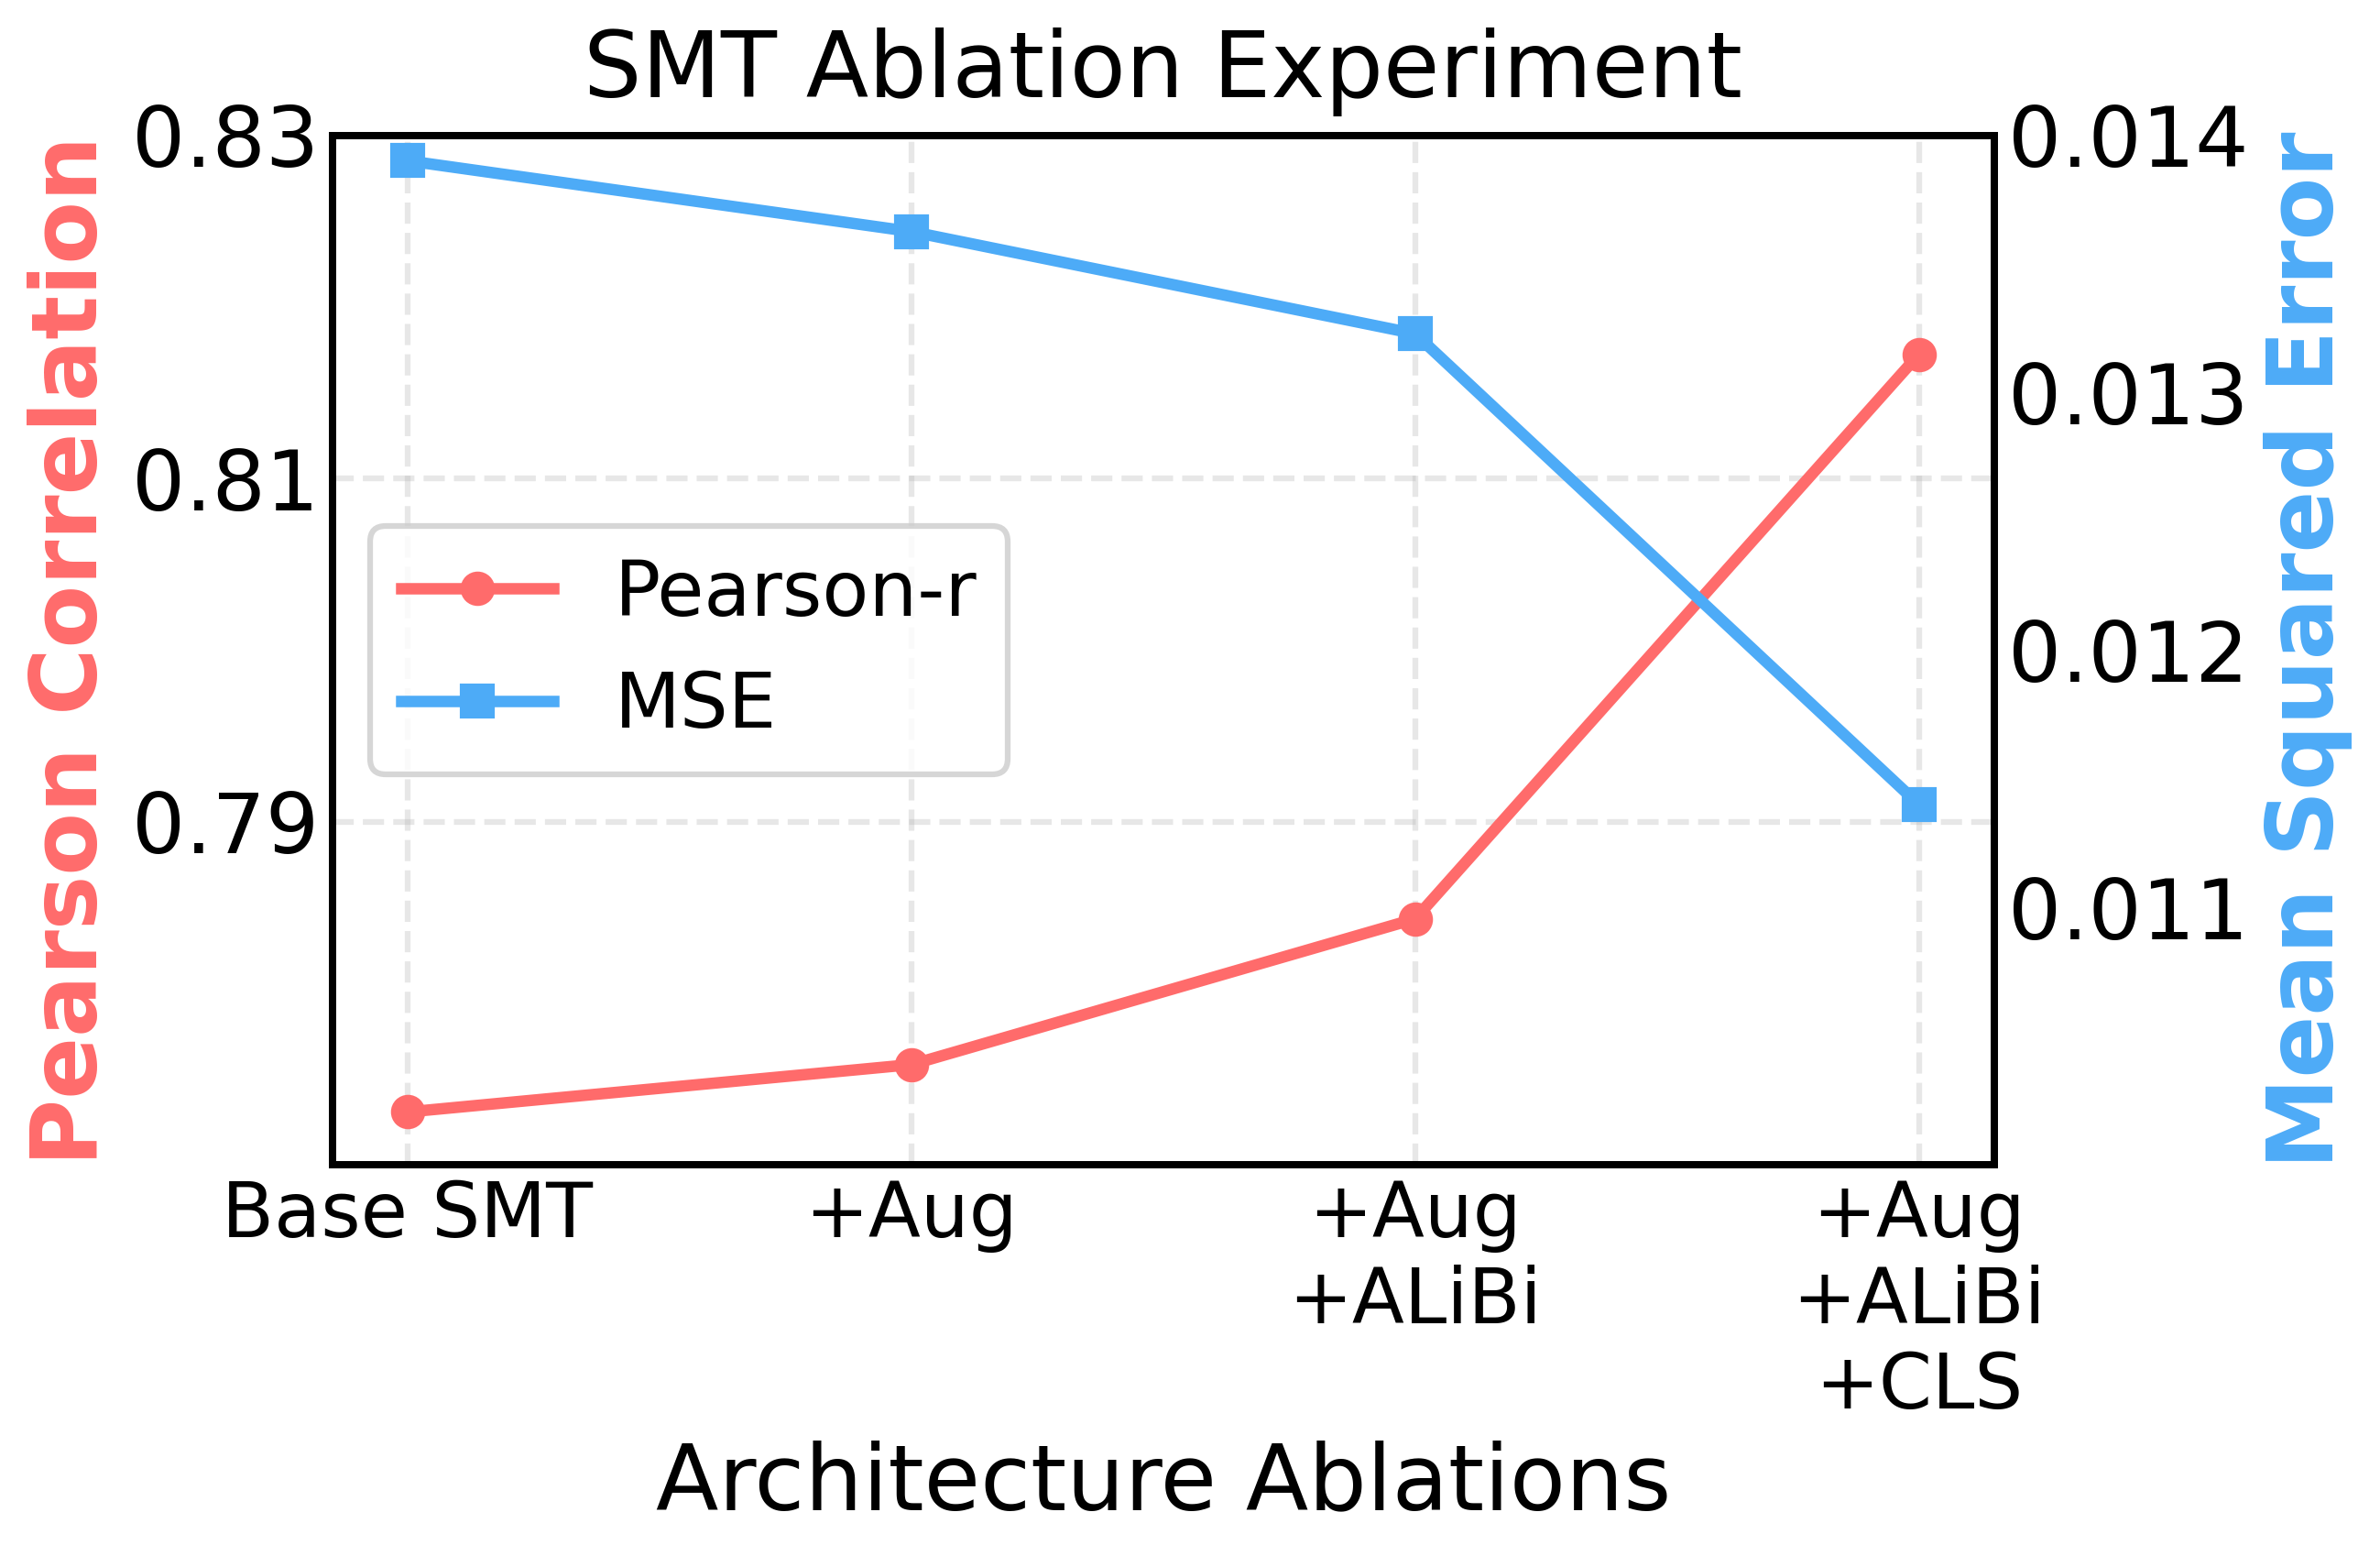

In [20]:
# Create figure showing performance improvements with each feature
FONT_SIZE = 24  # Global font size parameter
plt.figure(figsize=(9, 6), dpi=300)  # Wider figure, higher DPI for publication quality

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()

plt.title('SMT Ablation Experiment', pad=10, fontsize=FONT_SIZE)

# Get data in order
subset_models = ['no_slope_no_aug_no_cls', 'no_slope_no_cls', 'no_cls', 'full_model']
pearson_scores = []
mse_scores = []
for model in subset_models:
    df = ablation_dfs[model]
    pearson_scores.append(df['final_test_metrics.pearson_r'].mean())
    mse_scores.append(df['final_test_metrics.mse'].mean())

# X-axis labels
x_labels = [
    'Base SMT',
    '+Aug', 
    '+Aug\n+ALiBi',
    '+Aug\n+ALiBi\n+CLS'
]

x = range(len(x_labels))

# Softer colors
soft_red = '#ff6b6b'
soft_blue = '#4dabf7'
# Plot Pearson correlation (red) on left y-axis
line1 = ax1.plot(x, pearson_scores, color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
ax1.set_ylim([0.77, 0.83])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.02))  # Set tick interval to 0.02
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Format to 2 decimal places
ax1.set_yticks(np.arange(0.79, 0.84, 0.02))  # Start at 0.79, go to 0.83 in steps of 0.02
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)  # Remove ticks

# Plot MSE (blue) on right y-axis with sparser ticks
line2 = ax2.plot(x, mse_scores, color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
ax2.set_ylim([0.010, 0.014])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.001))  # Set tick interval to 0.001
ax2.set_yticks(np.arange(0.011, 0.015, 0.001))  # Start at 0.011, go to 0.014 in steps of 0.001
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)  # Remove ticks

# X-axis formatting
plt.xticks(x, x_labels, rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
plt.xlabel('Ablations', fontsize=FONT_SIZE)
ax1.set_xlabel('Architecture Ablations', fontsize=FONT_SIZE)
# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Add legend for metrics
lines1 = line1 + line2
labels = [l.get_label() for l in lines1]
ax1.legend(lines1, labels, loc='center left', fontsize=FONT_SIZE-4)

plt.tight_layout()
plt.show()


<Figure size 2700x1800 with 0 Axes>

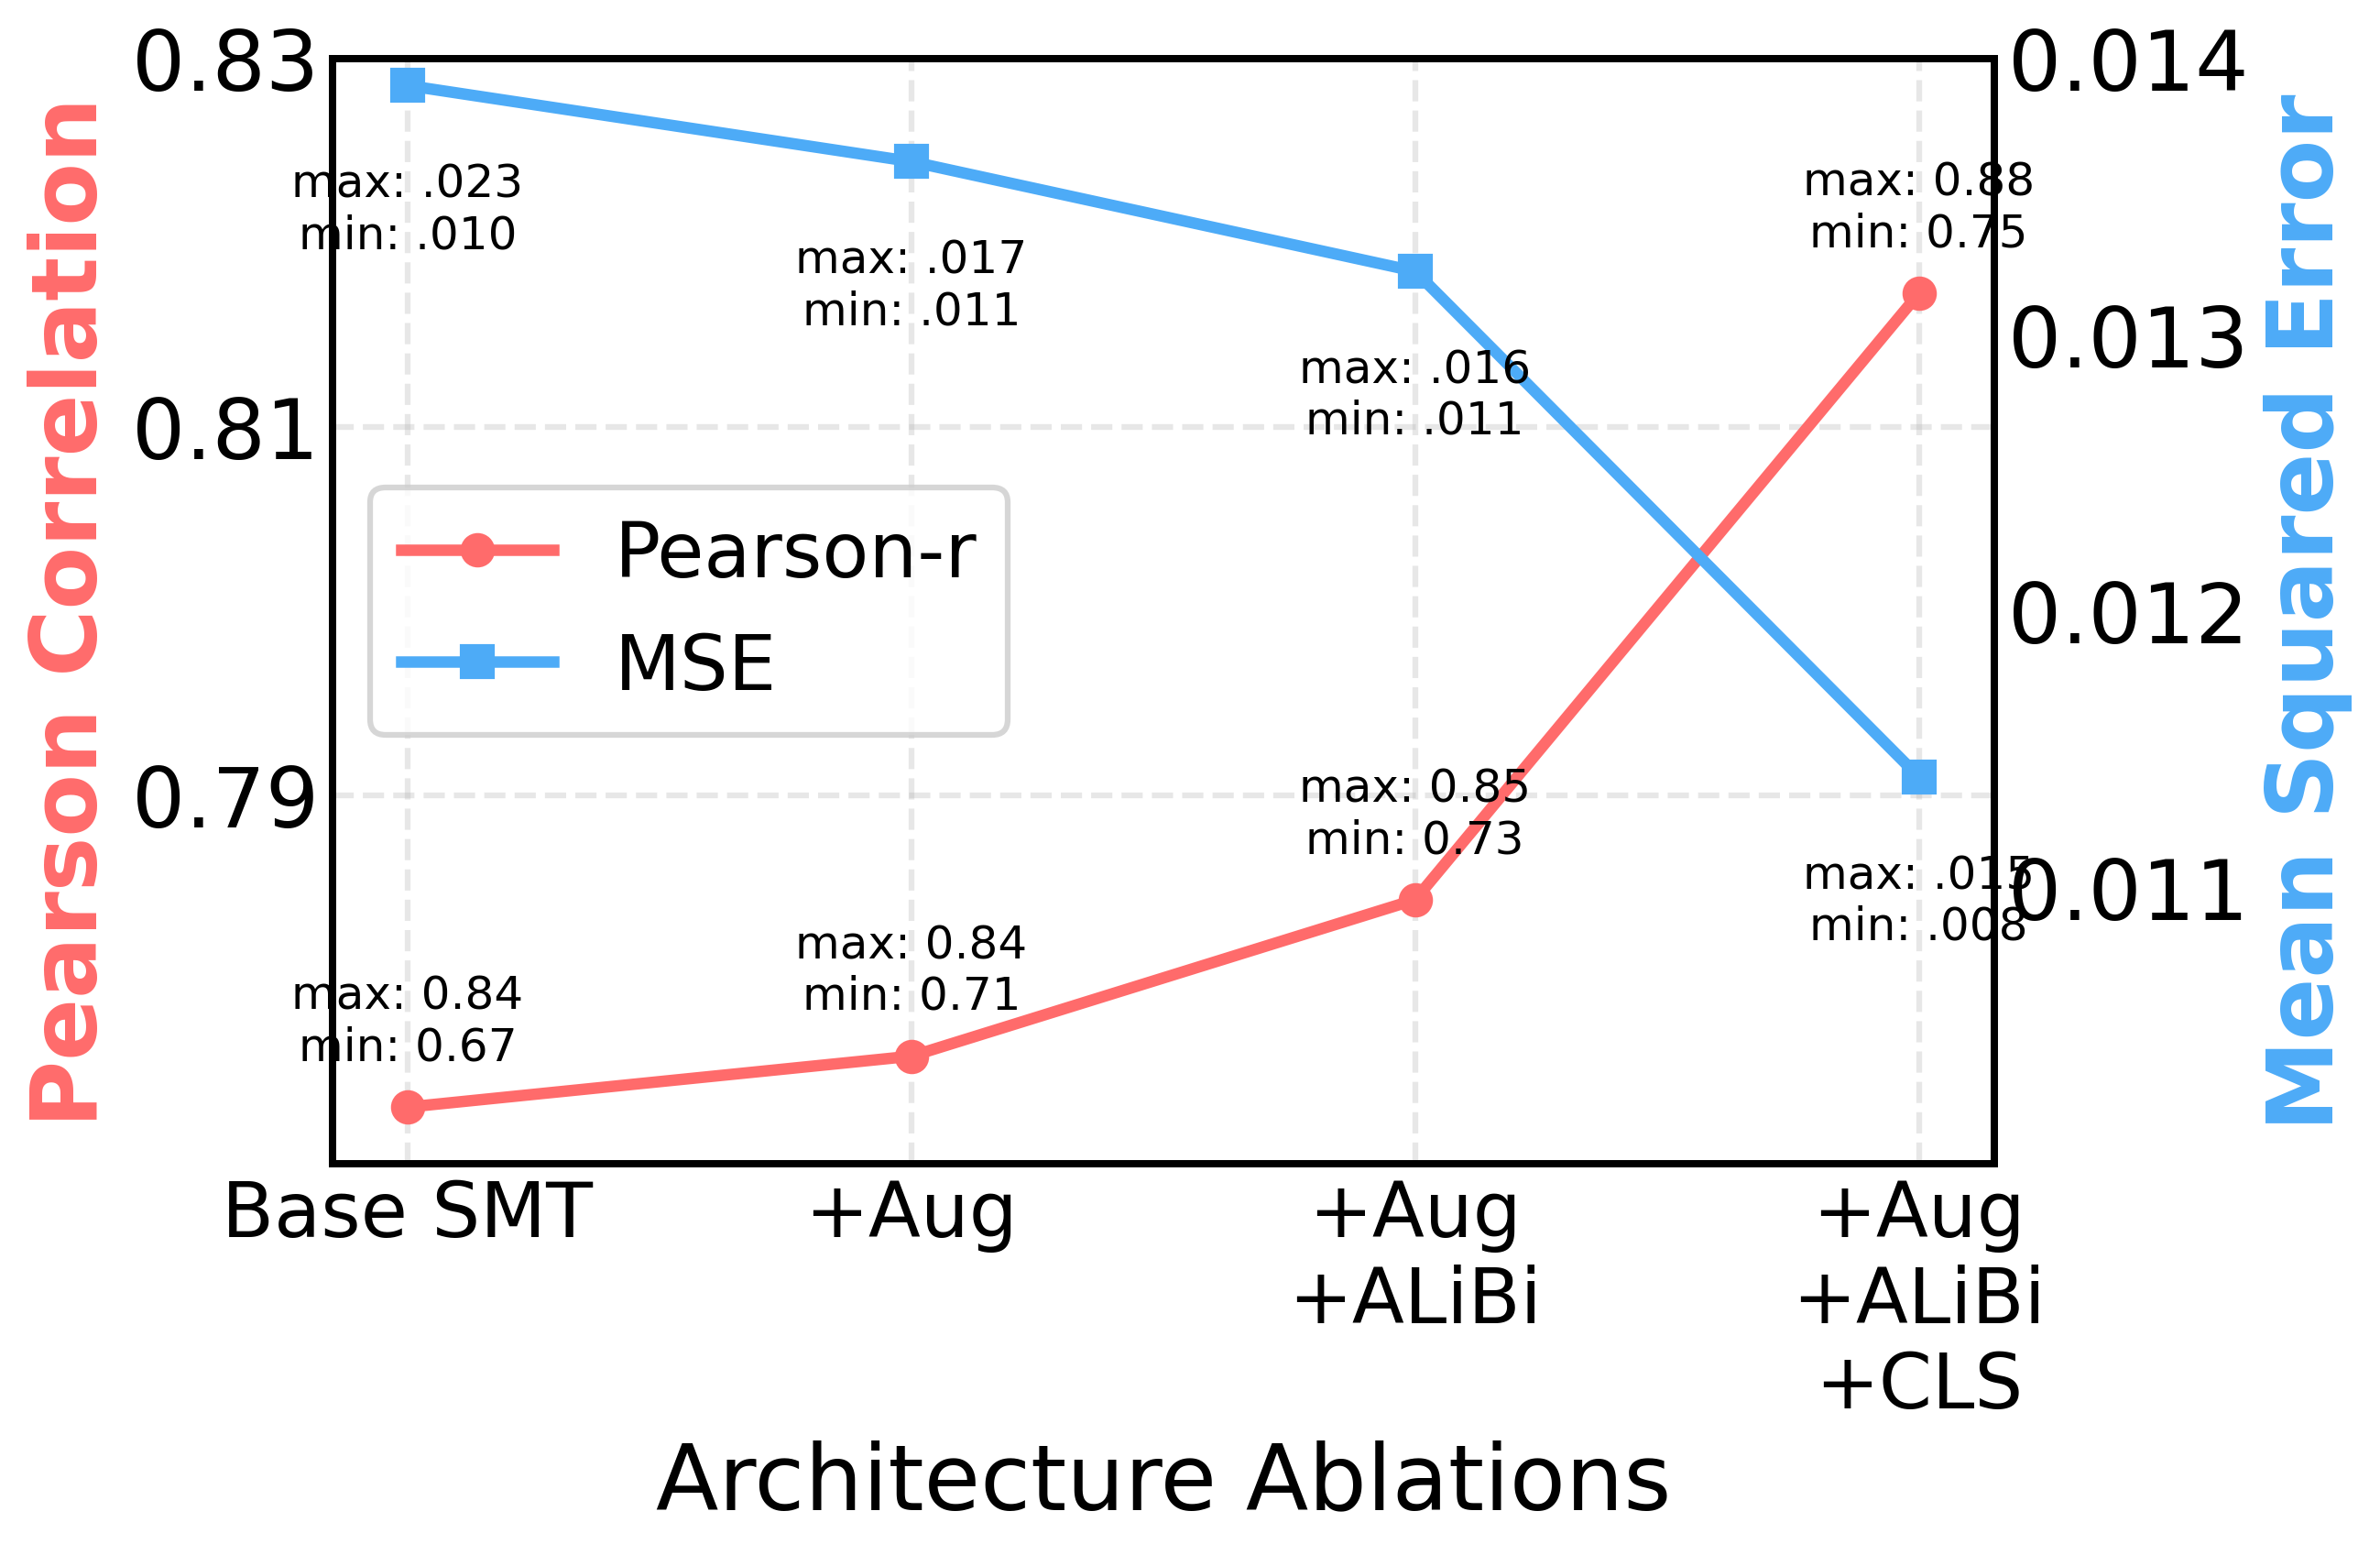

In [25]:
# Create figure showing performance improvements with each feature
# Create figure showing performance improvements with each feature
FONT_SIZE = 24  # Global font size parameter
plt.figure(figsize=(9, 6), dpi=300)  # Wider figure, higher DPI for publication quality

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()

# Get data in order
subset_models = ['no_slope_no_aug_no_cls', 'no_slope_no_cls', 'no_cls', 'full_model']
pearson_scores = []
pearson_ranges = []
mse_scores = []
mse_ranges = []
for model in subset_models:
    df = ablation_dfs[model]
    pearson_mean = df['final_test_metrics.pearson_r'].mean()
    pearson_min = df['final_test_metrics.pearson_r'].min()
    pearson_max = df['final_test_metrics.pearson_r'].max()
    pearson_scores.append(pearson_mean)
    pearson_ranges.append([pearson_min, pearson_max])
    
    mse_mean = df['final_test_metrics.mse'].mean()
    mse_min = df['final_test_metrics.mse'].min()
    mse_max = df['final_test_metrics.mse'].max()
    mse_scores.append(mse_mean)
    mse_ranges.append([mse_min, mse_max])

# X-axis labels
x_labels = [
    'Base SMT',
    '+Aug', 
    '+Aug\n+ALiBi',
    '+Aug\n+ALiBi\n+CLS'
]

x = range(len(x_labels))
# Softer colors
soft_red = '#ff6b6b'
soft_blue = '#4dabf7'

# Plot Pearson correlation (red) on left y-axis
line1 = ax1.plot(x, pearson_scores, color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add range annotations above points for Pearson
for i, (score, range_vals) in enumerate(zip(pearson_scores, pearson_ranges)):
    ax1.annotate(f'max: {range_vals[1]:.2f}\nmin: {range_vals[0]:.2f}', 
                 xy=(i, score), xytext=(0, 10),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-12)

ax1.set_ylim([0.77, 0.83])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax1.set_yticks(np.arange(0.79, 0.84, 0.02))
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE (blue) on right y-axis
line2 = ax2.plot(x, mse_scores, color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add range annotations below points for MSE
for i, (score, range_vals) in enumerate(zip(mse_scores, mse_ranges)):
    # Format numbers without leading zeros
    min_str = f"{range_vals[0]:.3f}".replace('0.', '.')
    max_str = f"{range_vals[1]:.3f}".replace('0.', '.')
    ax2.annotate(f'max: {max_str}\nmin: {min_str}', 
                 xy=(i, score), xytext=(0, -20),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-12)

ax2.set_ylim([0.010, 0.014])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.001))
ax2.set_yticks(np.arange(0.011, 0.015, 0.001))
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, x_labels, rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
plt.xlabel('Ablations', fontsize=FONT_SIZE)
ax1.set_xlabel('Architecture Ablations', fontsize=FONT_SIZE)
# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Add legend for metrics
lines1 = line1 + line2
labels = [l.get_label() for l in lines1]
ax1.legend(lines1, labels, loc='center left', fontsize=FONT_SIZE-4)

plt.tight_layout()
plt.show()


<Figure size 2700x1800 with 0 Axes>

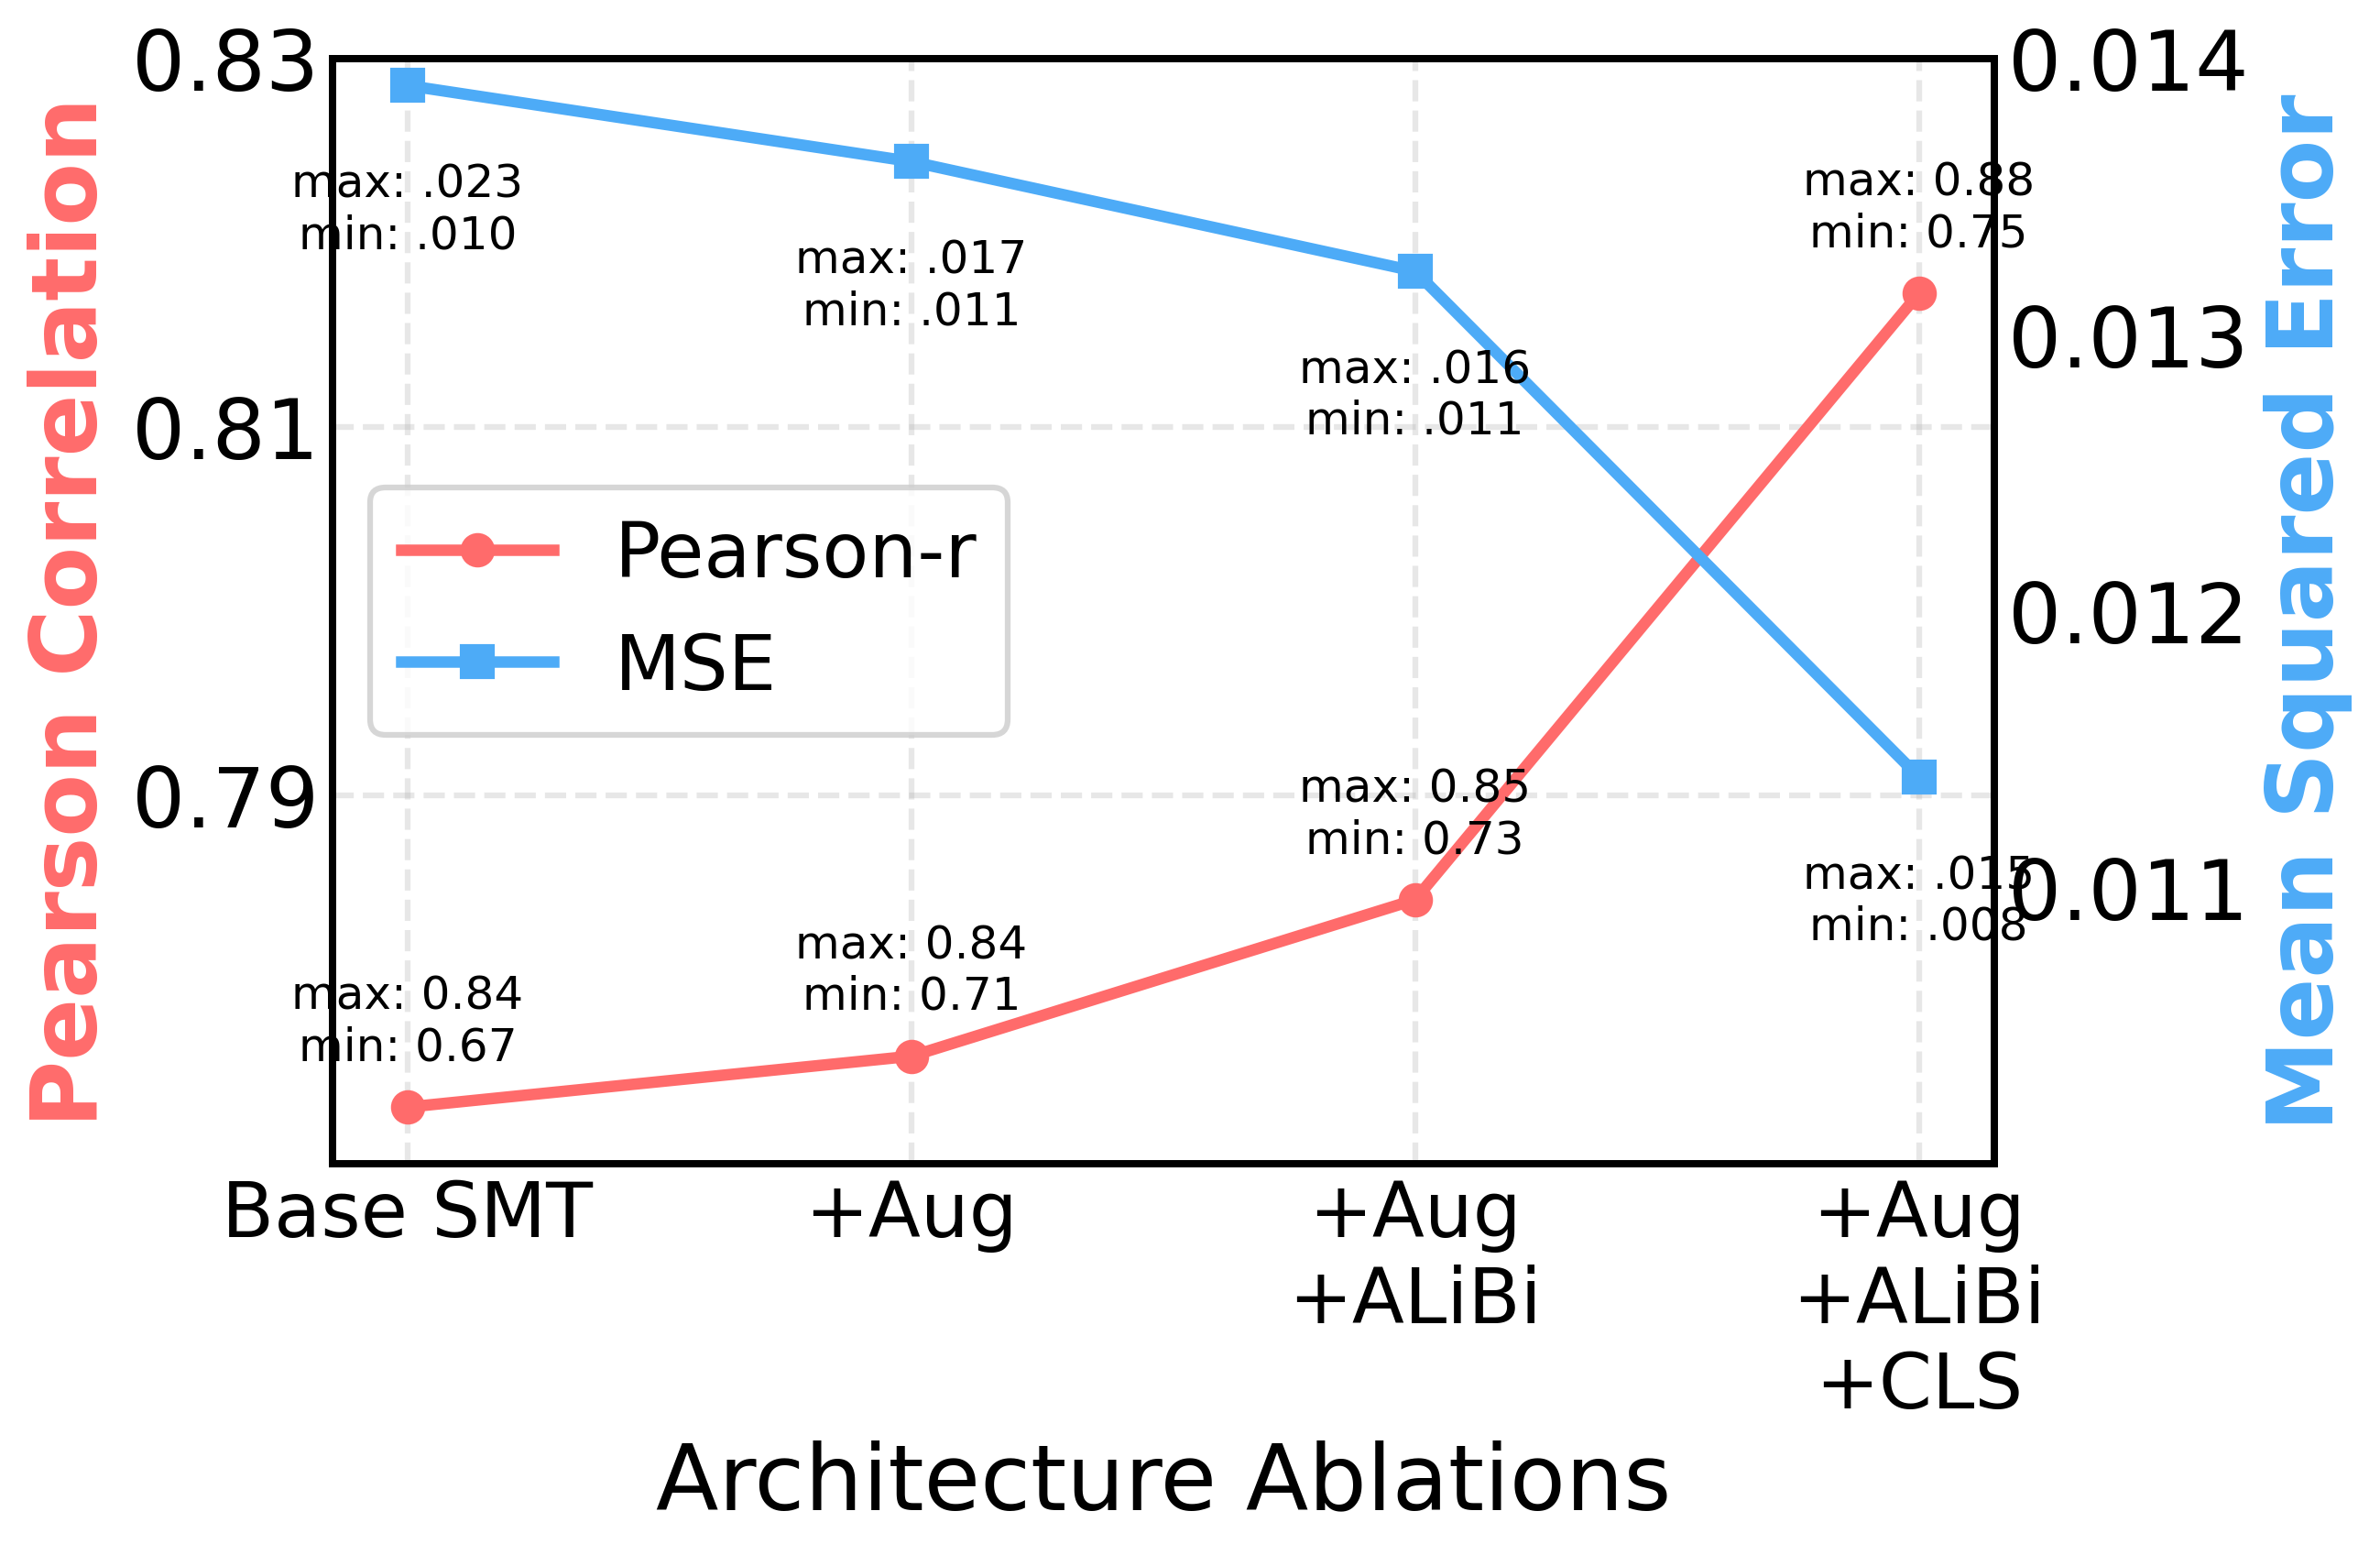

In [26]:
# Create figure showing performance improvements with each feature
FONT_SIZE = 24  # Global font size parameter
plt.figure(figsize=(9, 6), dpi=300)  # Wider figure, higher DPI for publication quality

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()

# Get data in order
subset_models = ['no_slope_no_aug_no_cls', 'no_slope_no_cls', 'no_cls', 'full_model']
pearson_scores = []
pearson_ranges = []
mse_scores = []
mse_ranges = []
for model in subset_models:
    df = ablation_dfs[model]
    pearson_mean = df['final_test_metrics.pearson_r'].mean()
    pearson_min = df['final_test_metrics.pearson_r'].min()
    pearson_max = df['final_test_metrics.pearson_r'].max()
    pearson_scores.append(pearson_mean)
    pearson_ranges.append([pearson_min, pearson_max])
    
    mse_mean = df['final_test_metrics.mse'].mean()
    mse_min = df['final_test_metrics.mse'].min()
    mse_max = df['final_test_metrics.mse'].max()
    mse_scores.append(mse_mean)
    mse_ranges.append([mse_min, mse_max])

# X-axis labels
x_labels = [
    'Base SMT',
    '+Aug', 
    '+Aug\n+ALiBi',
    '+Aug\n+ALiBi\n+CLS'
]

x = range(len(x_labels))
# Softer colors
soft_red = '#ff6b6b'
soft_blue = '#4dabf7'

# Plot Pearson correlation (red) on left y-axis
line1 = ax1.plot(x, pearson_scores, color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add range annotations above points for Pearson
for i, (score, range_vals) in enumerate(zip(pearson_scores, pearson_ranges)):
    ax1.annotate(f'max: {range_vals[1]:.2f}\nmin: {range_vals[0]:.2f}', 
                 xy=(i, score), xytext=(0, 10),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-12)

ax1.set_ylim([0.77, 0.83])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax1.set_yticks(np.arange(0.79, 0.84, 0.02))
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE (blue) on right y-axis
line2 = ax2.plot(x, mse_scores, color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add range annotations below points for MSE
for i, (score, range_vals) in enumerate(zip(mse_scores, mse_ranges)):
    # Format numbers without leading zeros
    min_str = f"{range_vals[0]:.3f}".replace('0.', '.')
    max_str = f"{range_vals[1]:.3f}".replace('0.', '.')
    ax2.annotate(f'max: {max_str}\nmin: {min_str}', 
                 xy=(i, score), xytext=(0, -20),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-12)

ax2.set_ylim([0.010, 0.014])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.001))
ax2.set_yticks(np.arange(0.011, 0.015, 0.001))
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, x_labels, rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
plt.xlabel('Ablations', fontsize=FONT_SIZE)
ax1.set_xlabel('Architecture Ablations', fontsize=FONT_SIZE)
# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Add legend for metrics
lines1 = line1 + line2
labels = [l.get_label() for l in lines1]
ax1.legend(lines1, labels, loc='center left', fontsize=FONT_SIZE-4)

plt.tight_layout()


<Figure size 2700x1800 with 0 Axes>

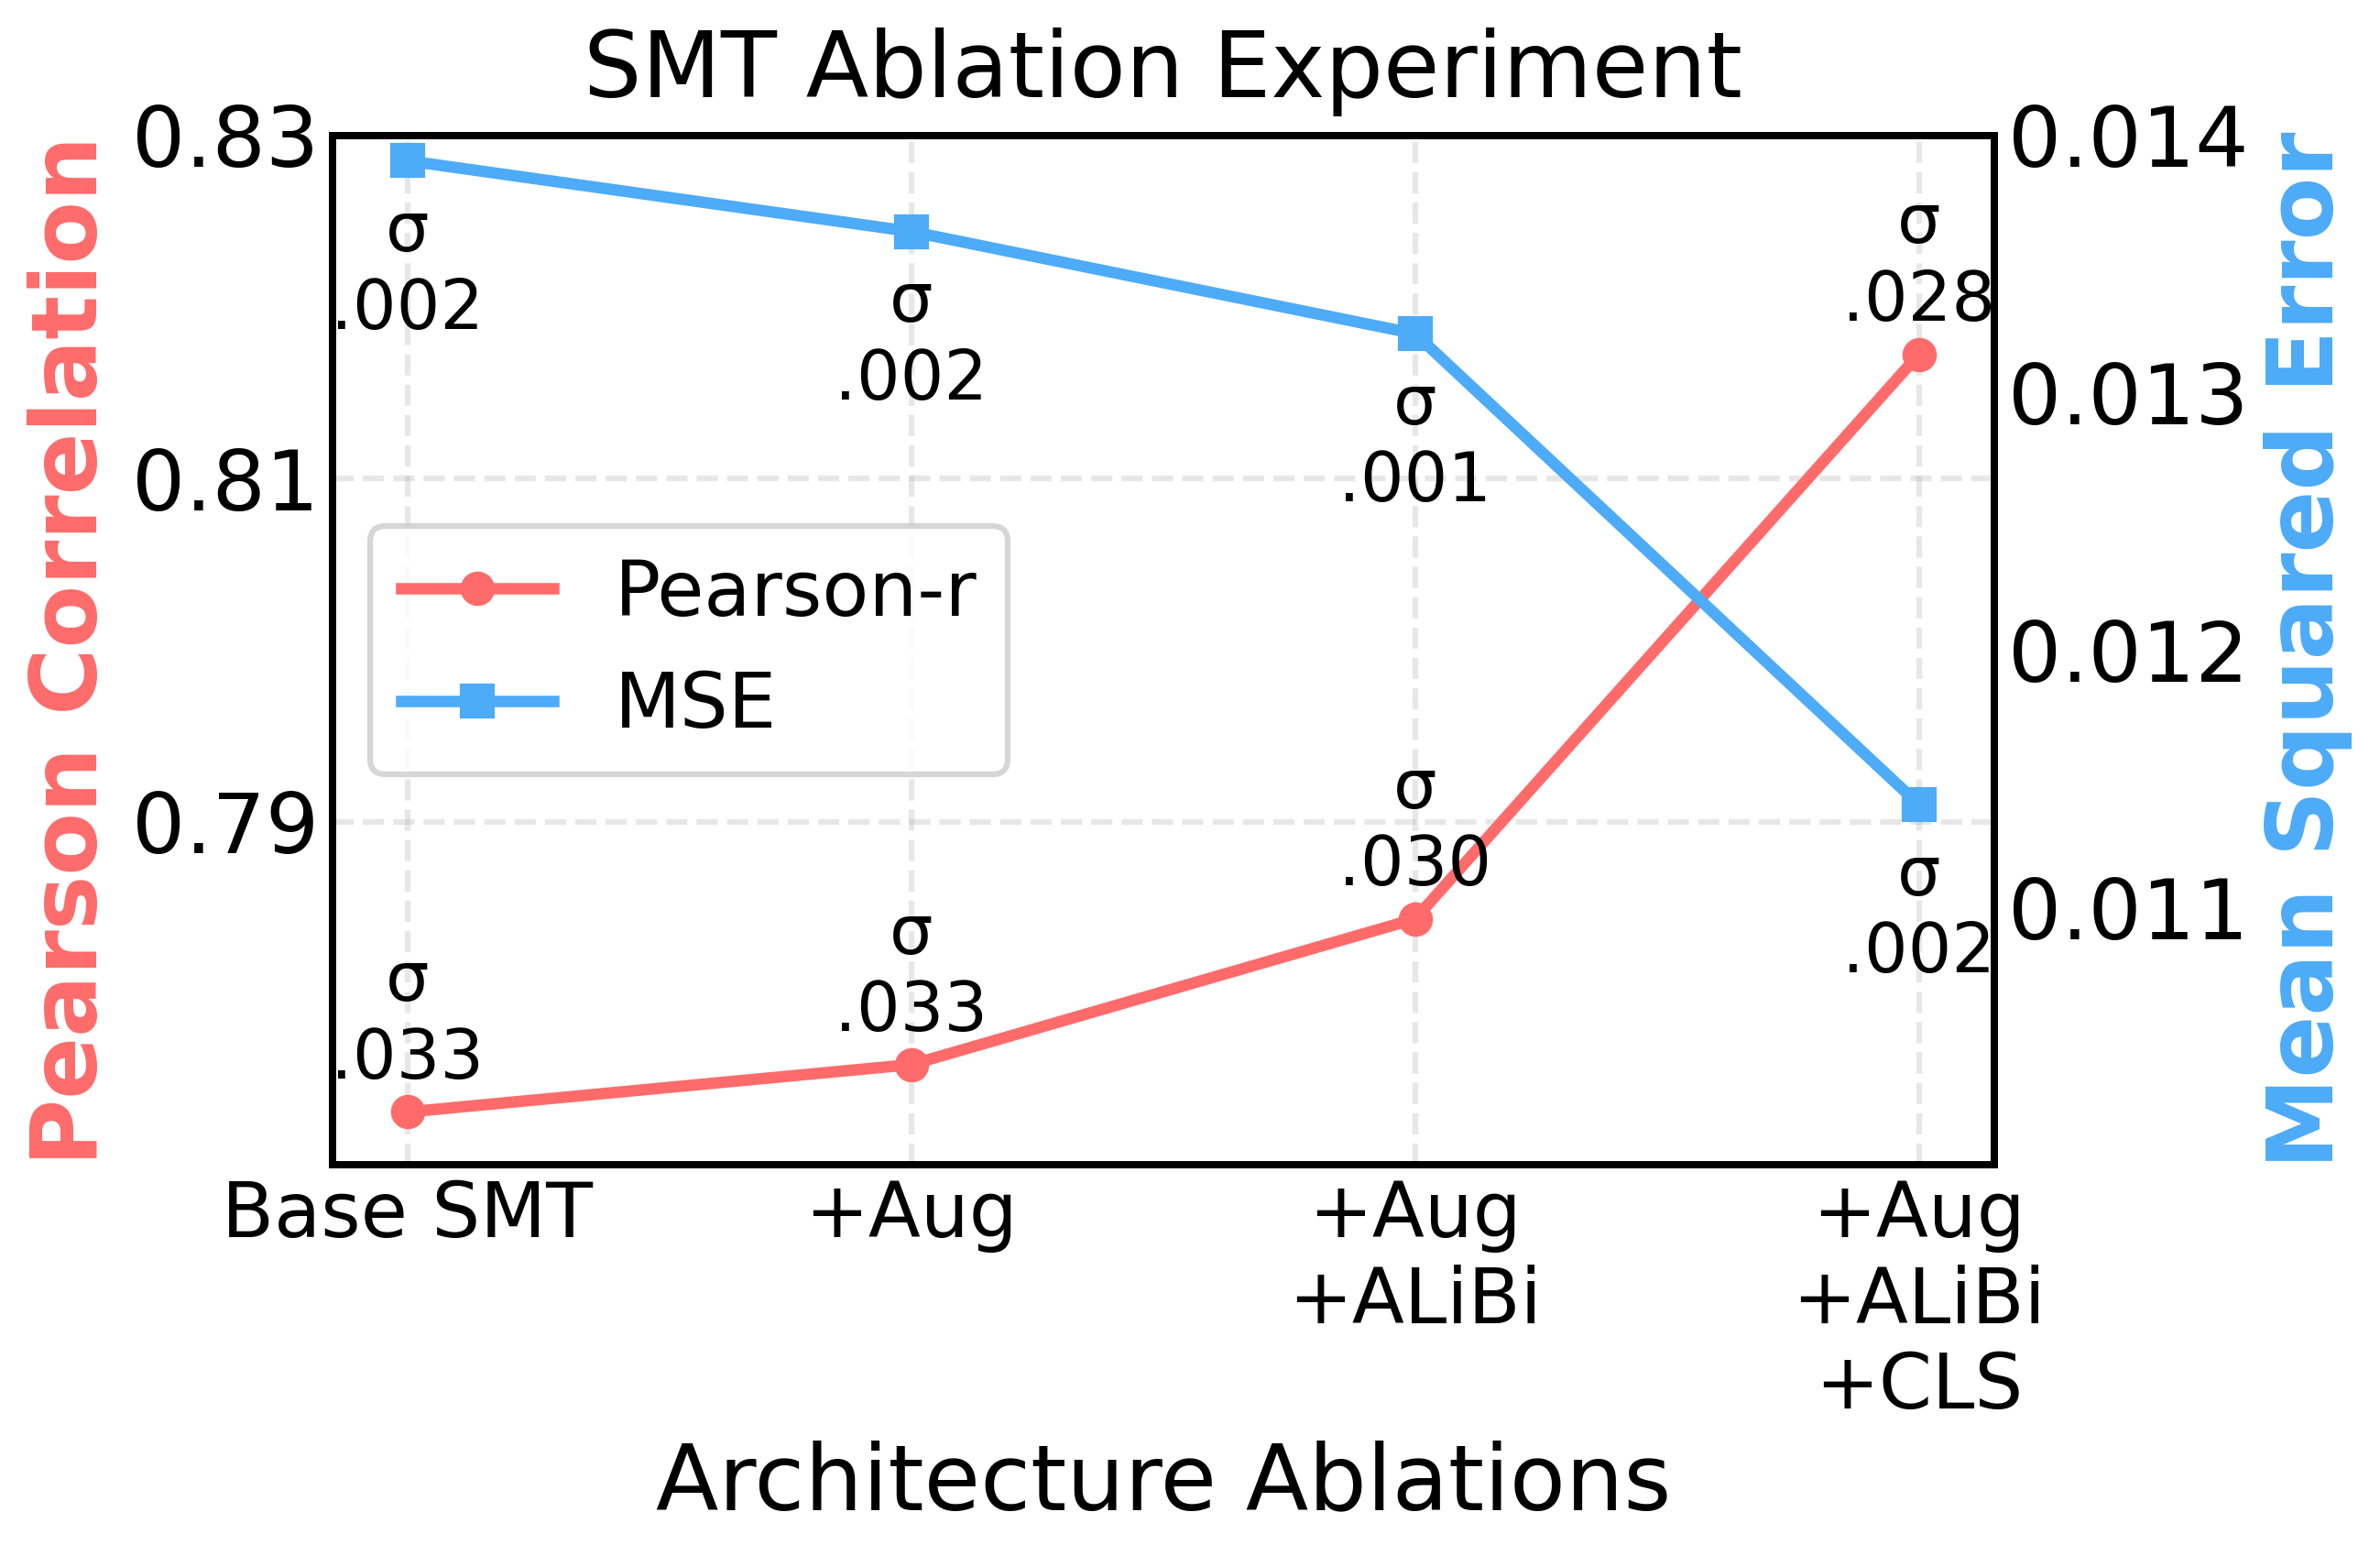

In [27]:
# Create figure showing performance improvements with each feature
FONT_SIZE = 24  # Global font size parameter
plt.figure(figsize=(9, 6), dpi=300)  # Wider figure, higher DPI for publication quality

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()

# Add title
plt.title('SMT Ablation Experiment', pad=10, fontsize=FONT_SIZE)

# Get data in order
subset_models = ['no_slope_no_aug_no_cls', 'no_slope_no_cls', 'no_cls', 'full_model']
pearson_scores = []
pearson_stds = []
mse_scores = []
mse_stds = []
for model in subset_models:
    df = ablation_dfs[model]
    pearson_mean = df['final_test_metrics.pearson_r'].mean()
    pearson_std = df['final_test_metrics.pearson_r'].std()
    pearson_scores.append(pearson_mean)
    pearson_stds.append(pearson_std)
    
    mse_mean = df['final_test_metrics.mse'].mean()
    mse_std = df['final_test_metrics.mse'].std()
    mse_scores.append(mse_mean)
    mse_stds.append(mse_std)

# X-axis labels
x_labels = [
    'Base SMT',
    '+Aug', 
    '+Aug\n+ALiBi',
    '+Aug\n+ALiBi\n+CLS'
]

x = range(len(x_labels))
# Softer colors
soft_red = '#ff6b6b'
soft_blue = '#4dabf7'

# Plot Pearson correlation (red) on left y-axis
line1 = ax1.plot(x, pearson_scores, color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(pearson_scores, pearson_stds)):
    # Remove leading zero
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

ax1.set_ylim([0.77, 0.83])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax1.set_yticks(np.arange(0.79, 0.84, 0.02))
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE (blue) on right y-axis
line2 = ax2.plot(x, mse_scores, color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(mse_scores, mse_stds)):
    # Remove leading zero
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

ax2.set_ylim([0.010, 0.014])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.001))
ax2.set_yticks(np.arange(0.011, 0.015, 0.001))
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, x_labels, rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
plt.xlabel('Ablations', fontsize=FONT_SIZE)
ax1.set_xlabel('Architecture Ablations', fontsize=FONT_SIZE)
# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Add legend for metrics
lines1 = line1 + line2
labels = [l.get_label() for l in lines1]
ax1.legend(lines1, labels, loc='center left', fontsize=FONT_SIZE-4)

plt.tight_layout()
plt.show()

In [28]:
'SMT: Spatiomolecular Transformer'
'Aug: Distributional Target Augmentation'
'ALiBi: Attention with Linear Biases'
'CLS: Euclidean coordinate CLS token'

'CLS: Euclidean coordinate CLS token'

### Parse transformer hyperparameter experiments

In [33]:
token_df = pd.read_csv('./notebooks/NeurIPS/results/hyperparam//token_size_experiment.csv')
target_aug_df = pd.read_csv('./notebooks/NeurIPS/results/hyperparam/target_aug_experiment.csv')
cls_df = pd.read_csv('./notebooks/NeurIPS/results/hyperparam/cls_experiment.csv')
alibi_df = pd.read_csv('./notebooks/NeurIPS/results/hyperparam/alibi_experiment.csv')


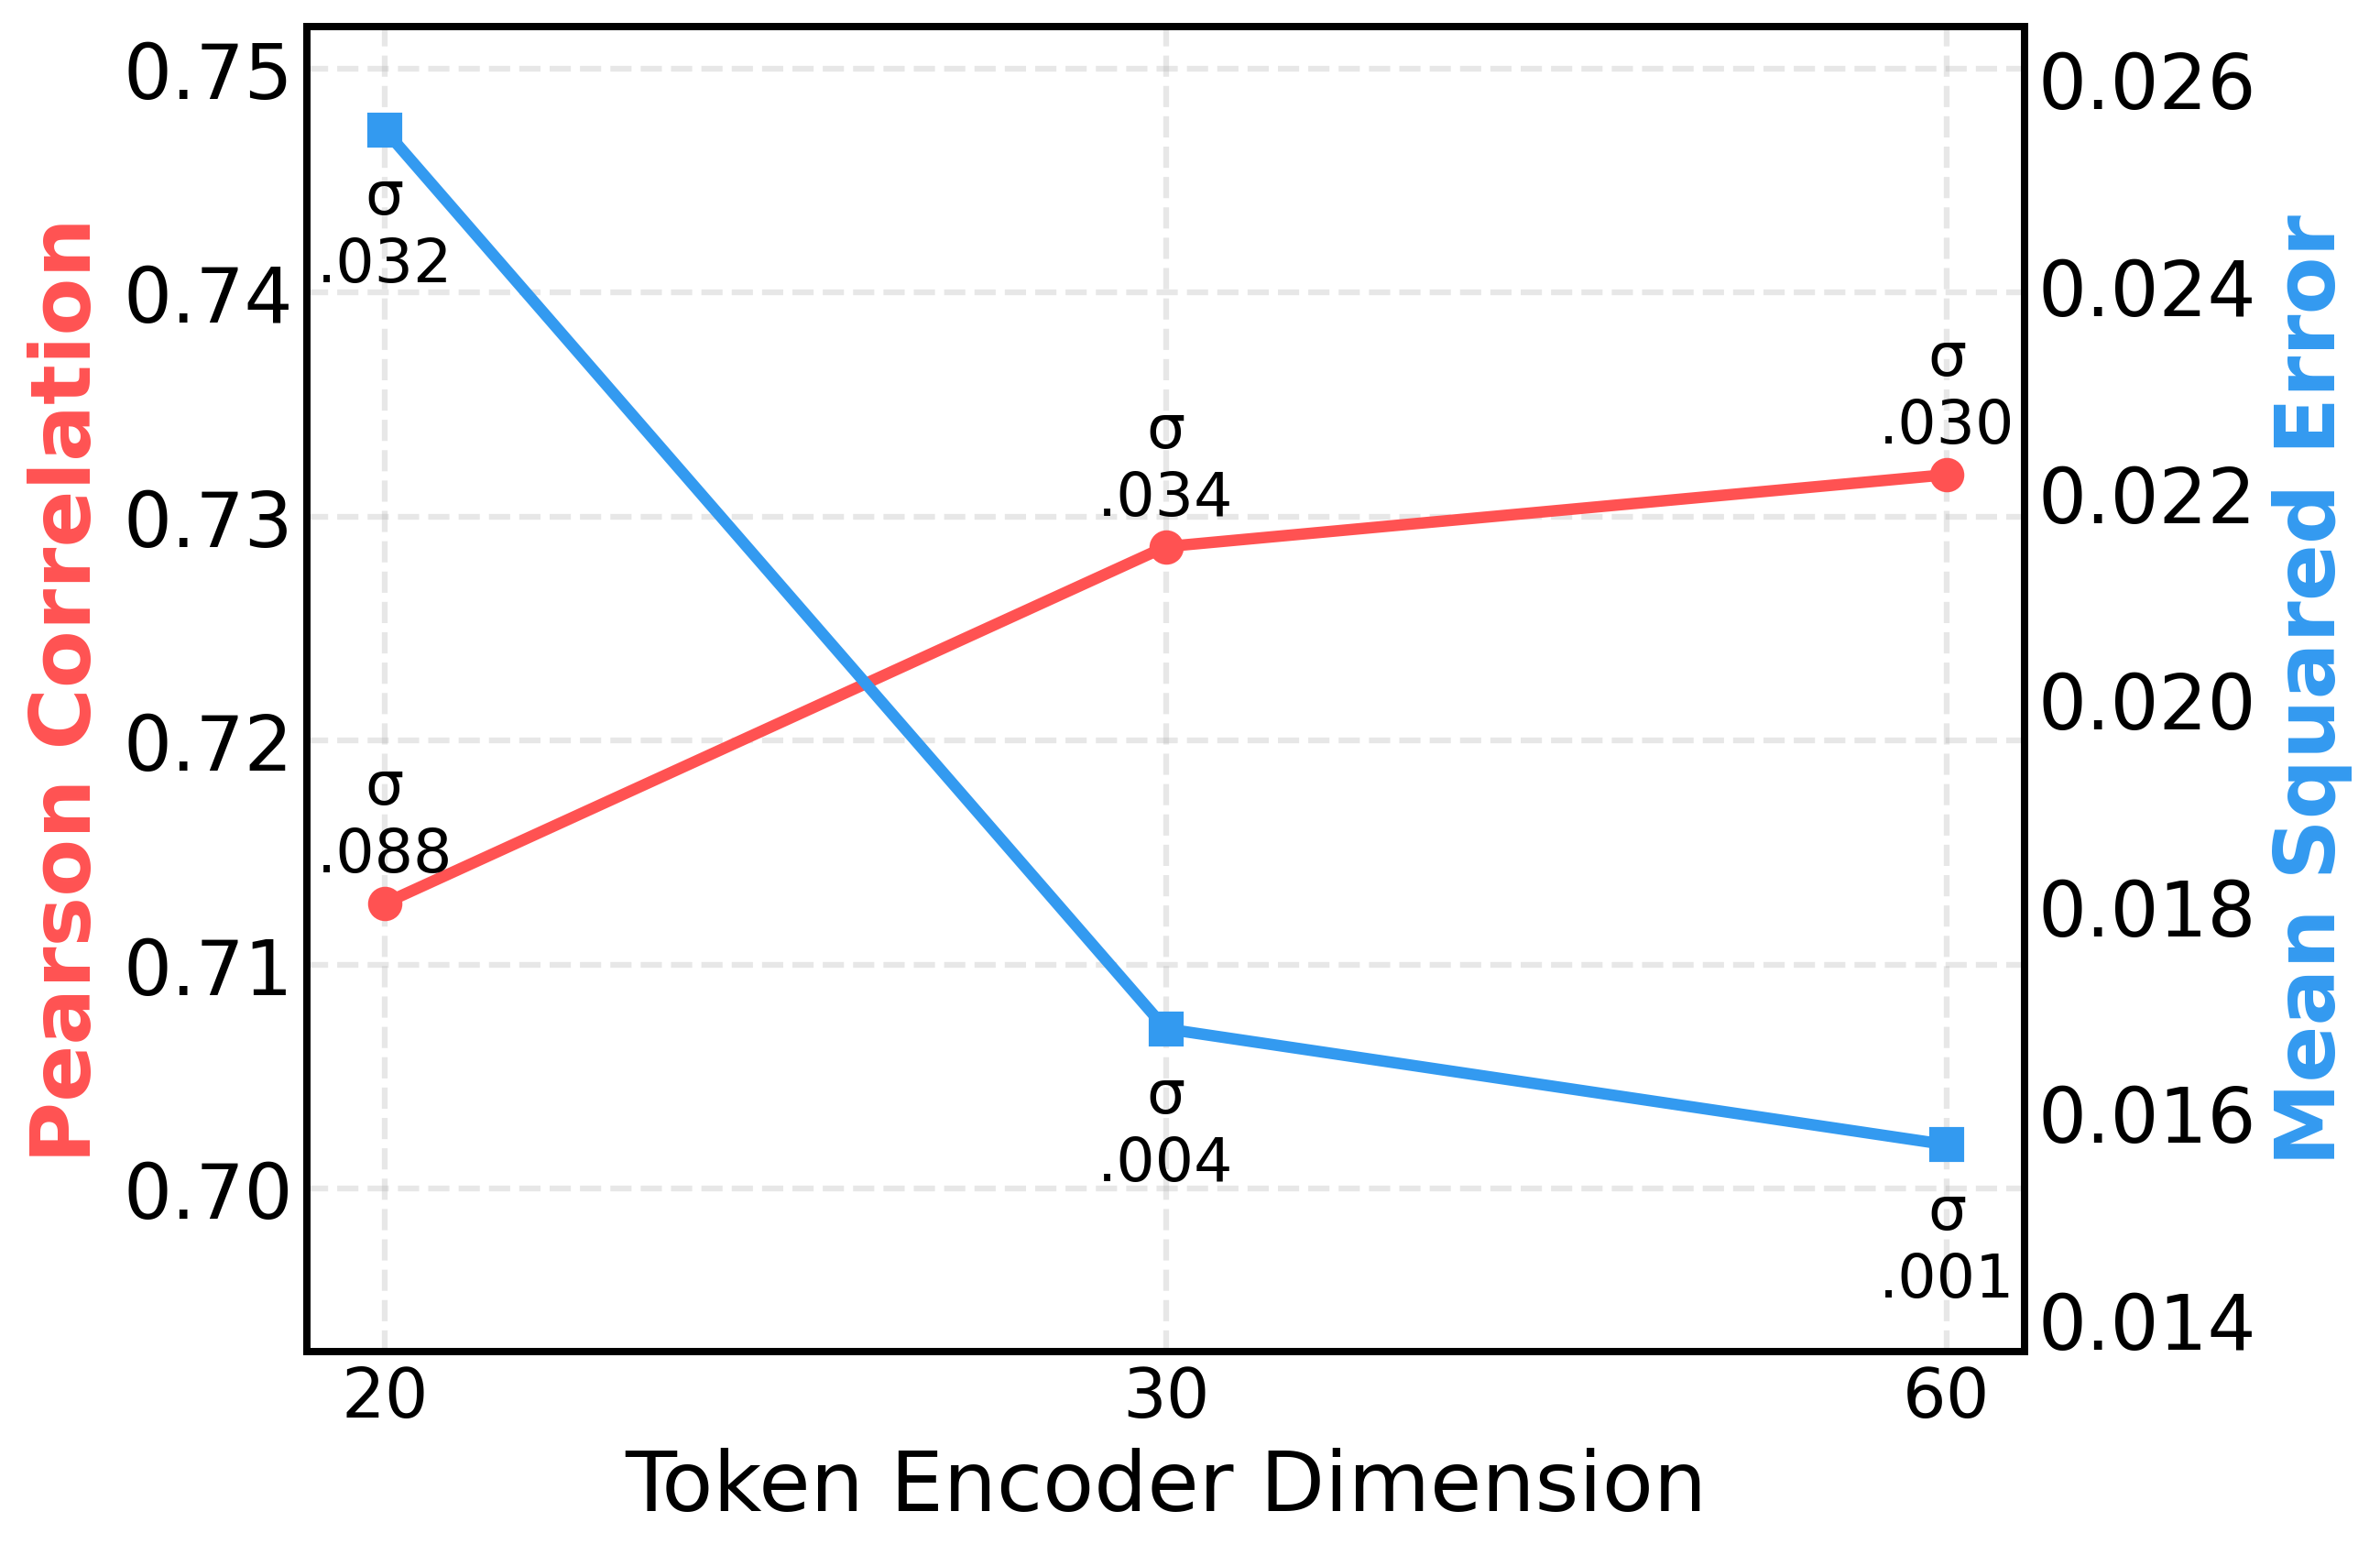

In [65]:
token_df.head(50)
# Drop rows where mean_val_loss is NaN
token_df = token_df.dropna(subset=['mean_val_loss'])
# Sort the dataframe by token_encoder_dim column
token_df = token_df.sort_values(by='token_encoder_dim')

token_df.head(50)

# Group by token_encoder_dim and calculate stats
token_pearson_stats = token_df.groupby('token_encoder_dim')['mean_val_pearson'].agg(['mean', 'std']).reset_index()
token_mse_stats = token_df.groupby('token_encoder_dim')['mean_val_loss'].agg(['mean', 'std']).reset_index()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(token_pearson_stats))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, token_pearson_stats['mean'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(token_pearson_stats['mean'], token_pearson_stats['std'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = token_pearson_stats['mean'].min() - 0.02
pearson_max = token_pearson_stats['mean'].max() + 0.02
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, token_mse_stats['mean'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(token_mse_stats['mean'], token_mse_stats['std'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = token_mse_stats['mean'].min() - 0.002
mse_max = token_mse_stats['mean'].max() + 0.001
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, token_pearson_stats['token_encoder_dim'], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('Token Encoder Dimension', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Add legend
'''
lines1 = line1 + line2
labels = [l.get_label() for l in lines1]
ax1.legend(lines1, labels, loc='center left', fontsize=FONT_SIZE-4)
'''

plt.tight_layout()
plt.show()


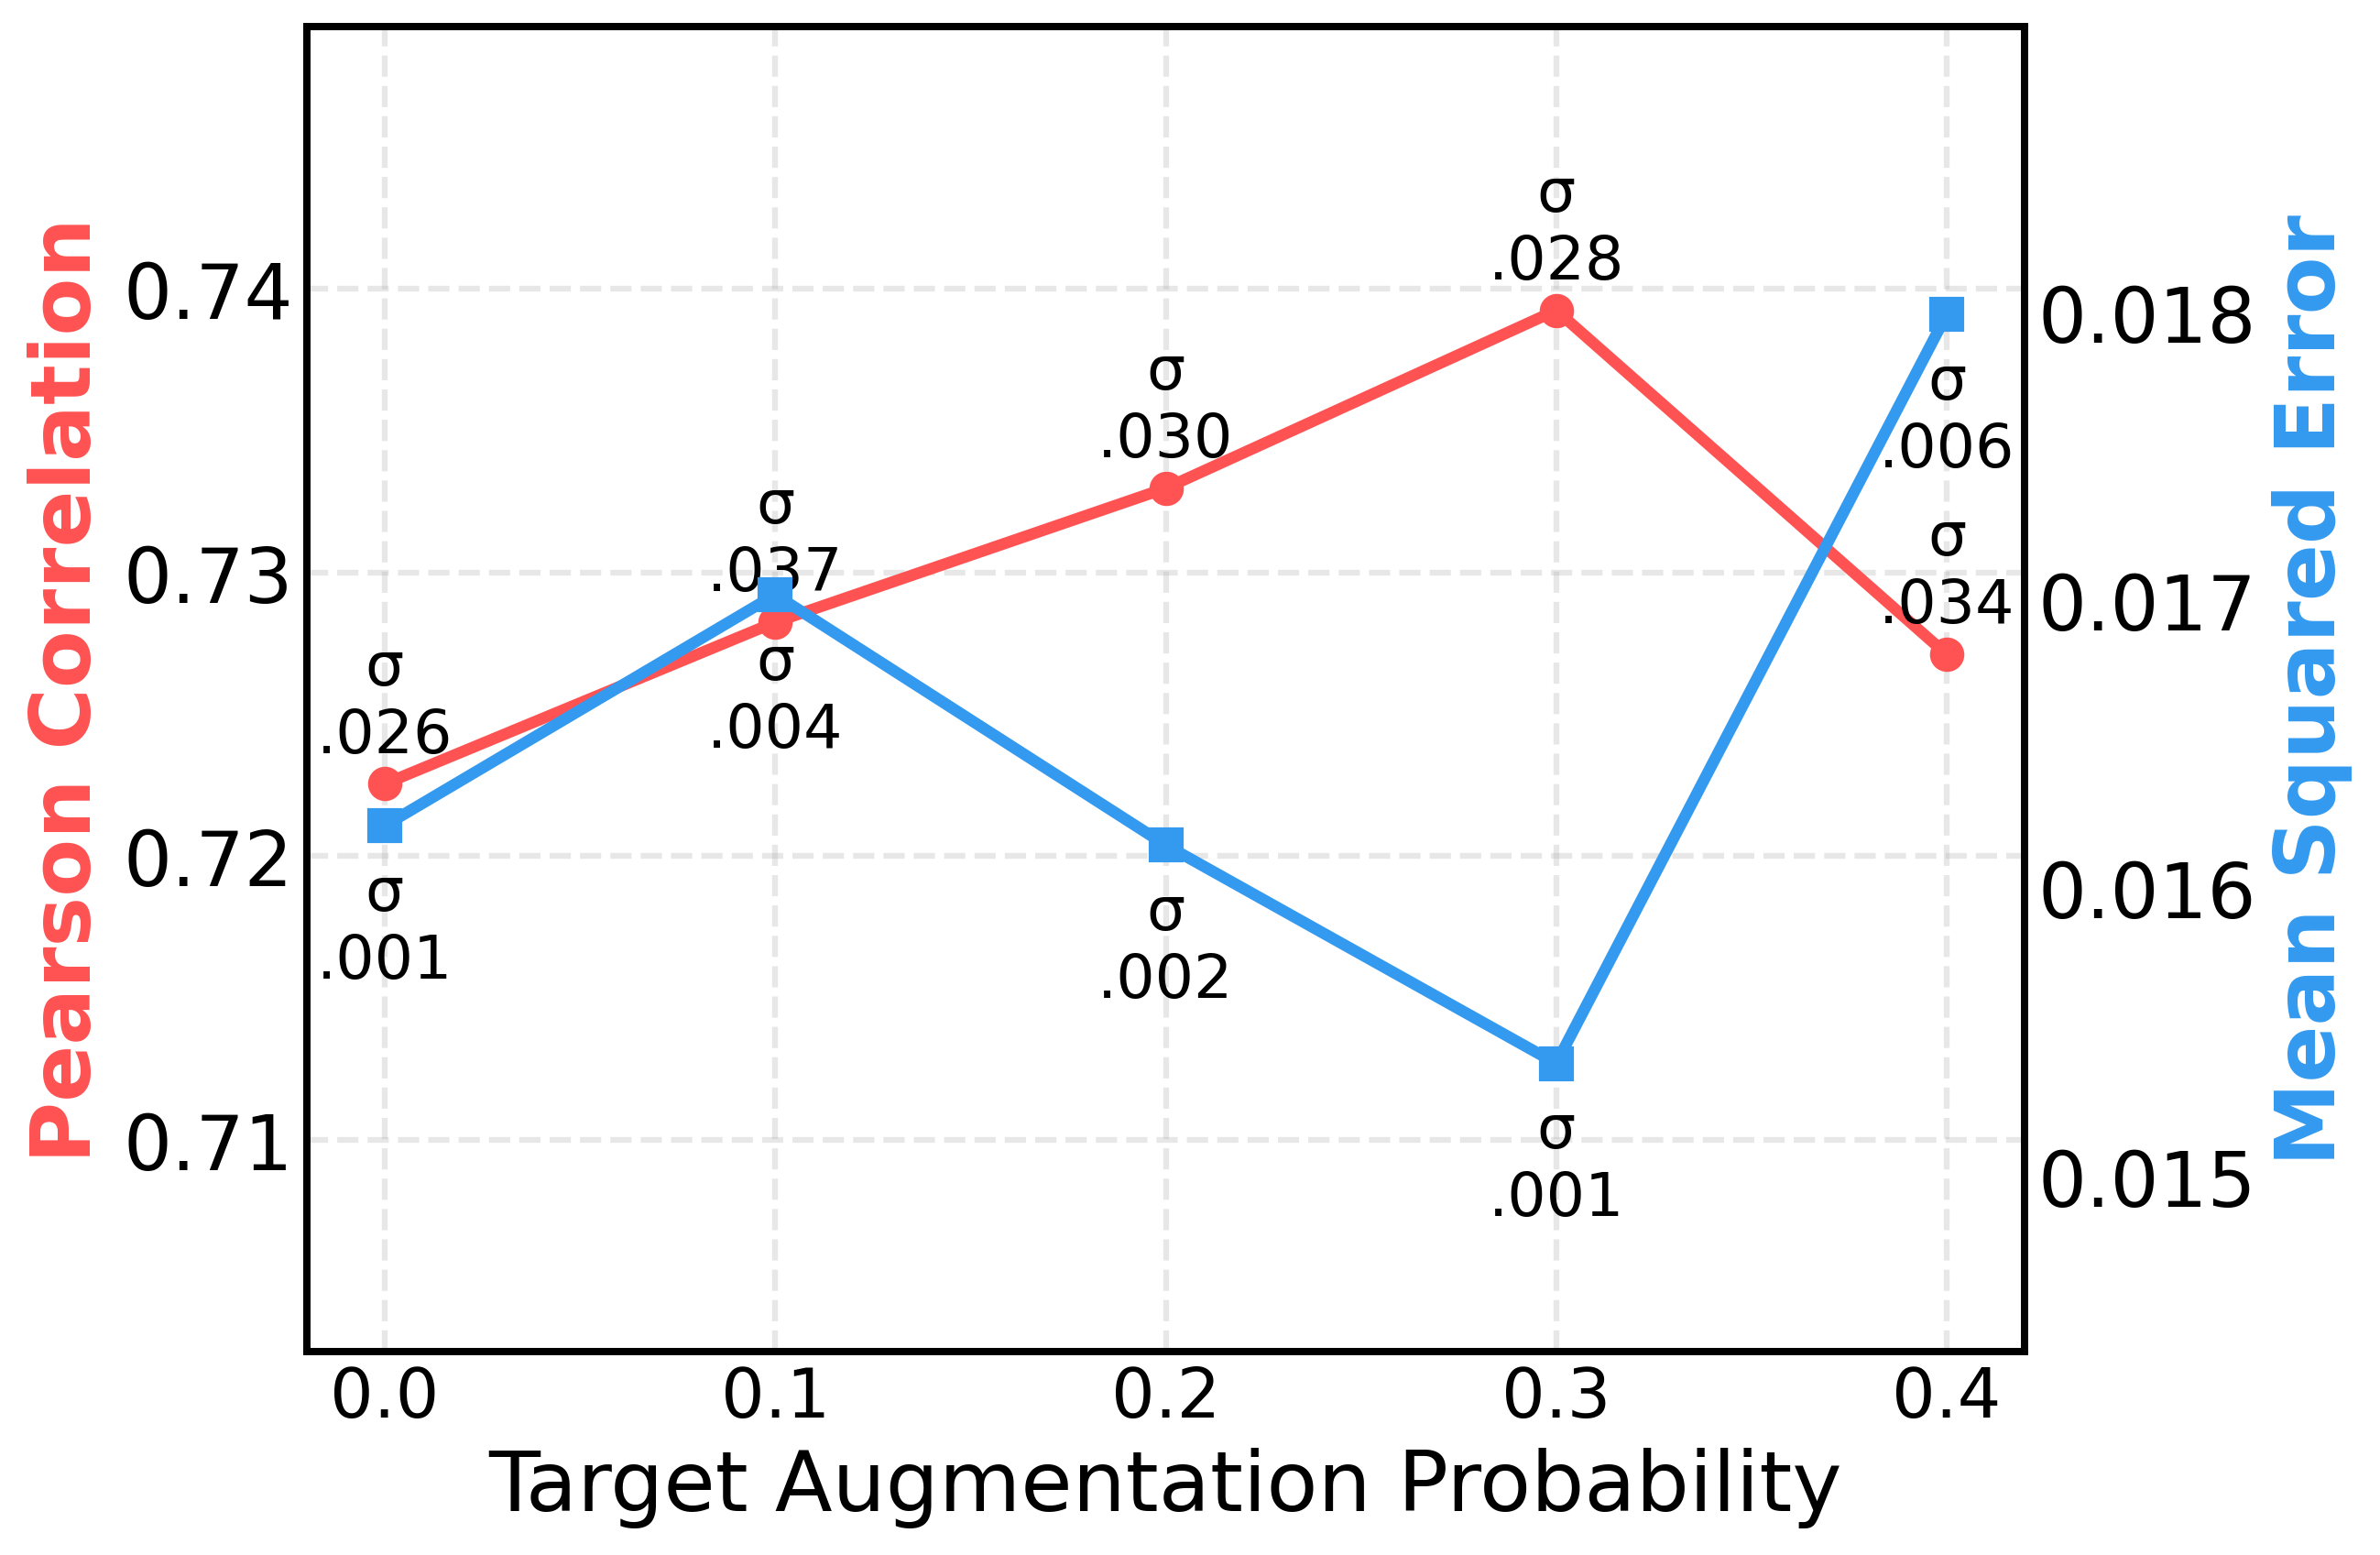

In [66]:
target_aug_df.head(50)
# Drop rows where mean_val_loss is NaN
target_aug_df = target_aug_df.dropna(subset=['mean_val_loss'])
# Sort the dataframe by aug_prob column
target_aug_df = target_aug_df.sort_values(by='aug_prob')

target_aug_df.head(50)

# Group by aug_prob and calculate stats
aug_pearson_stats = target_aug_df.groupby('aug_prob')['mean_val_pearson'].agg(['mean', 'std']).reset_index()
aug_mse_stats = target_aug_df.groupby('aug_prob')['mean_val_loss'].agg(['mean', 'std']).reset_index()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(aug_pearson_stats))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, aug_pearson_stats['mean'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(aug_pearson_stats['mean'], aug_pearson_stats['std'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = aug_pearson_stats['mean'].min() - 0.02
pearson_max = aug_pearson_stats['mean'].max() + 0.01
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, aug_mse_stats['mean'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(aug_mse_stats['mean'], aug_mse_stats['std'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = aug_mse_stats['mean'].min() - 0.001
mse_max = aug_mse_stats['mean'].max() + 0.001
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, aug_pearson_stats['aug_prob'], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('Target Augmentation Probability', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


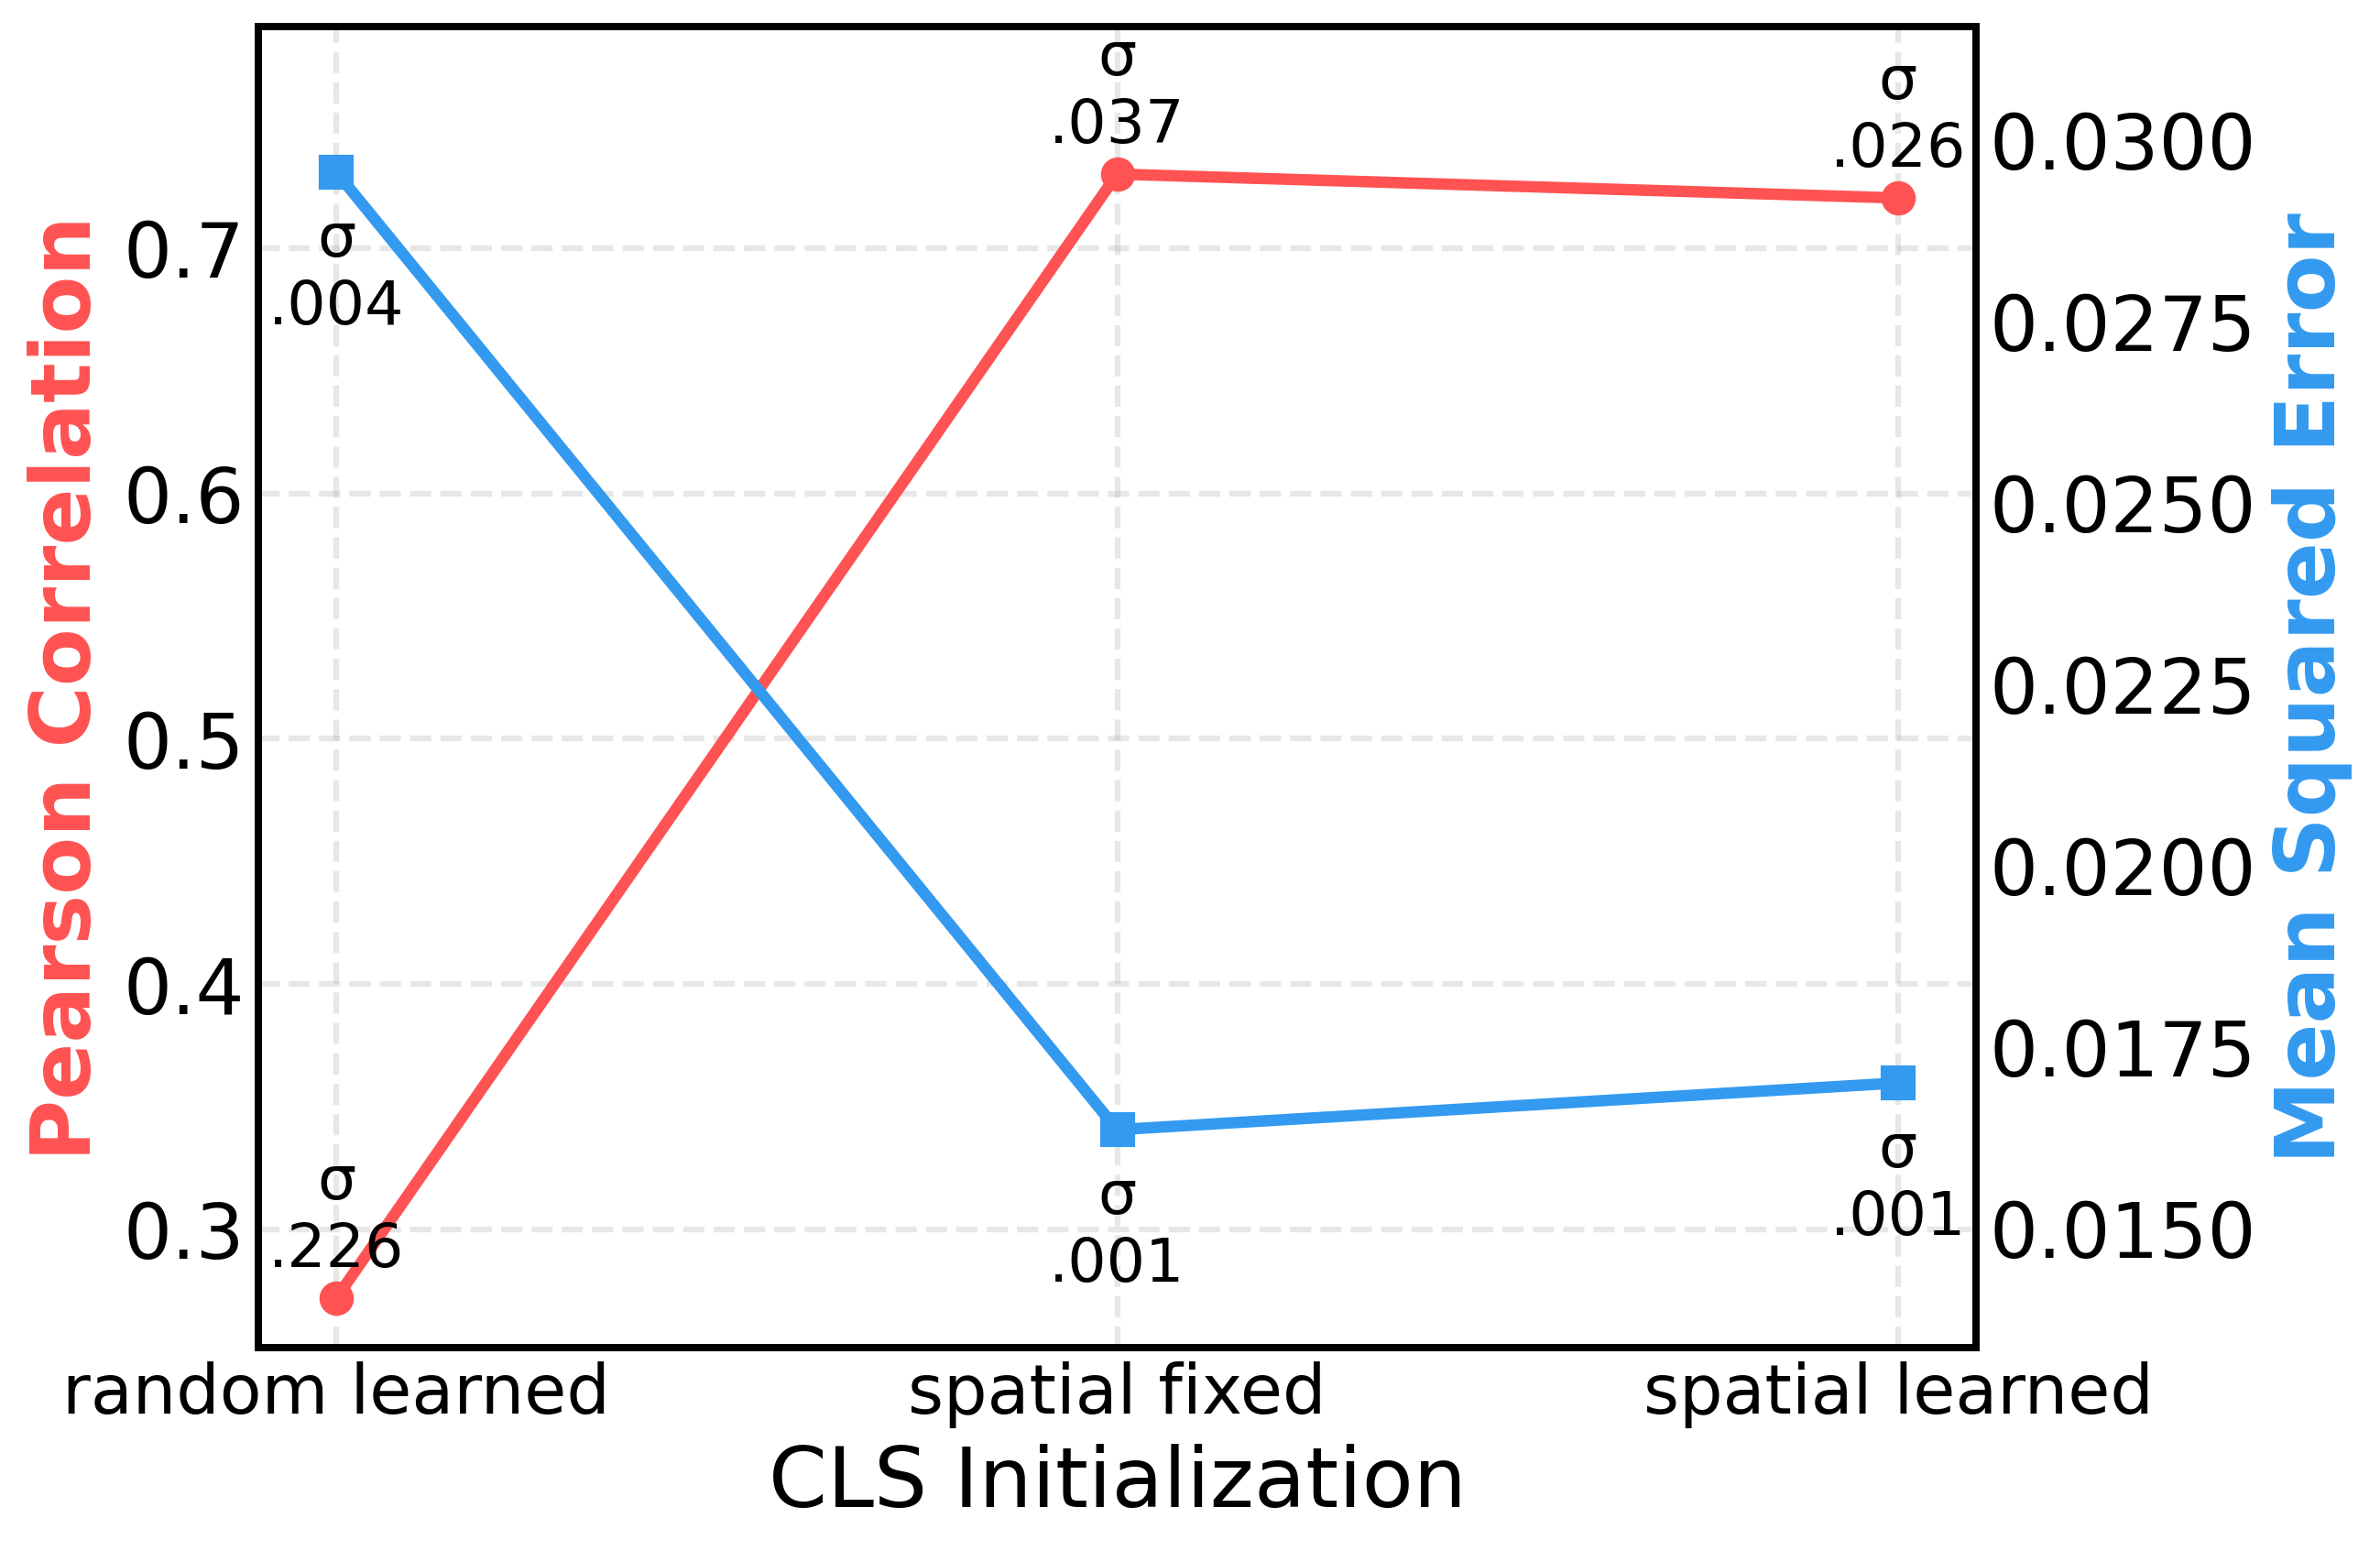

In [67]:
cls_df.head(50)
# Drop rows where mean_val_loss is NaN
cls_df = cls_df.dropna(subset=['mean_val_loss'])
# Sort the dataframe by cls_init column
cls_df = cls_df.sort_values(by='cls_init')

cls_df.head(50)

# Group by cls_init and calculate stats
cls_pearson_stats = cls_df.groupby('cls_init')['mean_val_pearson'].agg(['mean', 'std']).reset_index()
cls_mse_stats = cls_df.groupby('cls_init')['mean_val_loss'].agg(['mean', 'std']).reset_index()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(cls_pearson_stats))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, cls_pearson_stats['mean'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(cls_pearson_stats['mean'], cls_pearson_stats['std'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = cls_pearson_stats['mean'].min() - 0.02
pearson_max = cls_pearson_stats['mean'].max() + 0.06
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, cls_mse_stats['mean'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(cls_mse_stats['mean'], cls_mse_stats['std'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = cls_mse_stats['mean'].min() - 0.003
mse_max = cls_mse_stats['mean'].max() + 0.002
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, [label.replace('_', ' ') for label in cls_pearson_stats['cls_init']], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('CLS Initialization', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

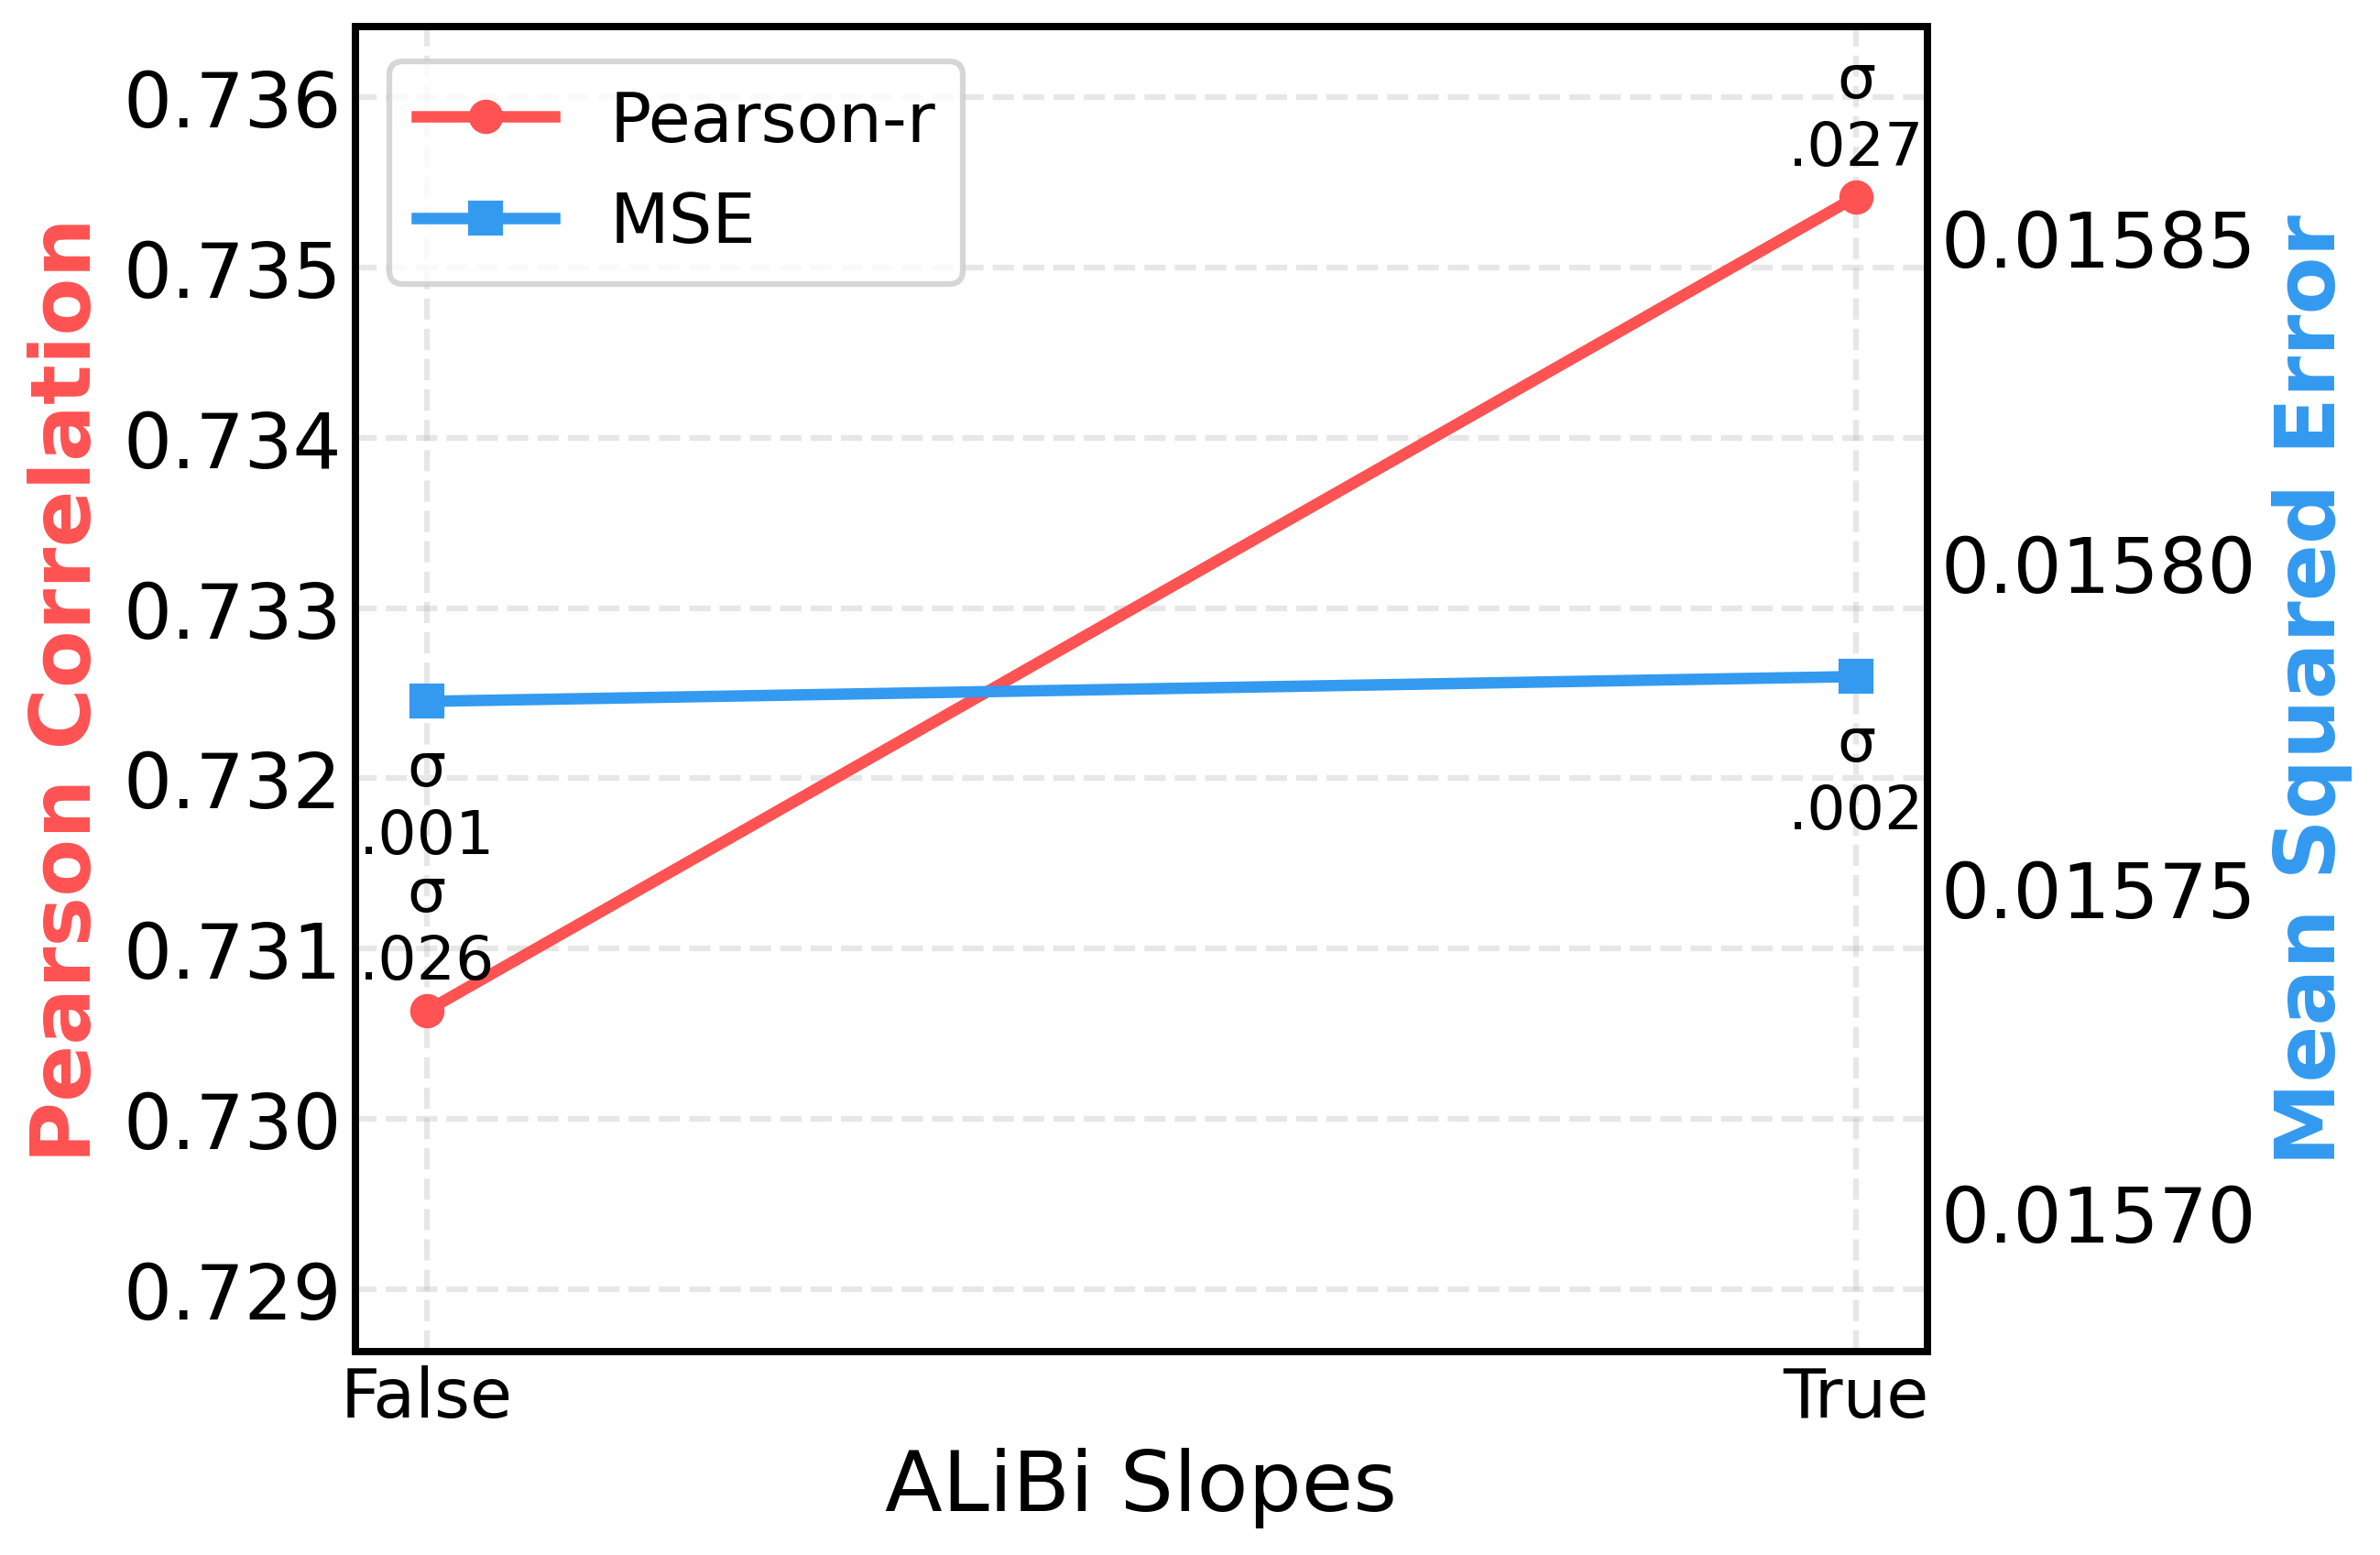

In [71]:
alibi_df.head(50)
# Drop rows where mean_val_loss is NaN
alibi_df = alibi_df.dropna(subset=['mean_val_loss'])
# Sort the dataframe by use_alibi column
alibi_df = alibi_df.sort_values(by='use_alibi')

alibi_df.head(50)

# Group by use_alibi and calculate stats
alibi_pearson_stats = alibi_df.groupby('use_alibi')['mean_val_pearson'].agg(['mean', 'std']).reset_index()
alibi_mse_stats = alibi_df.groupby('use_alibi')['mean_val_loss'].agg(['mean', 'std']).reset_index()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(alibi_pearson_stats))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, alibi_pearson_stats['mean'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(alibi_pearson_stats['mean'], alibi_pearson_stats['std'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = alibi_pearson_stats['mean'].min() - 0.002
pearson_max = alibi_pearson_stats['mean'].max() + 0.001
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, alibi_mse_stats['mean'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(alibi_mse_stats['mean'], alibi_mse_stats['std'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = alibi_mse_stats['mean'].min() - 0.0001
mse_max = alibi_mse_stats['mean'].max() + 0.0001
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, alibi_pearson_stats['use_alibi'], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('ALiBi Slopes', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

# Add legend for metrics
lines1 = line1 + line2
labels = [l.get_label() for l in lines1]
ax1.legend(lines1, labels, loc='upper left', fontsize=FONT_SIZE-4)

plt.tight_layout()
plt.show()